# Setup & Import packages

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import sys

notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

In [3]:
import config

import pytz
import numpy as np
import pandas as pd
import seaborn as sns
from loguru import logger
from datetime import datetime
from matplotlib import pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

In [4]:
pr_df = pd.read_parquet(config.PR_DF_PATH)

In [5]:
pr_commits_df = pd.read_parquet(config.PR_COMMITS_DF_PATH)

In [6]:
pr_commit_details_df = pd.read_parquet(config.PR_COMMIT_DETAILS_DF_PATH)

In [7]:
human_pr_df = pd.read_parquet(config.HUMAN_PR_DF_PATH)

# 2.1 Assess the PR description quality

## Semantic similarity between commit messages and PR description

In [21]:
human_pr_commit_details_df = pd.read_parquet(config.HUMAN_PR_COMMIT_DETAILS_DF_PATH)

In [22]:
human_pr_commit_details_df.head()

,sha,pr_id,file,status,additions,deletions,changes,patch,message,author,author_email,date
0,f76ad8971b774e58f2dd71fbdcb0cc669c1ab7f6,2354816036,Cargo.lock,modified,1,0,1,"@@ -3466,6 +3466,7 @@ dependencies = [\n ""ser...",[cleanup] Move tests from tools/state-viewer t...,Shreyan Gupta,shreyan.gupta96@gmail.com,2025-02-24T21:57:27Z
1,f76ad8971b774e58f2dd71fbdcb0cc669c1ab7f6,2354816036,integration-tests/Cargo.toml,modified,1,0,1,"@@ -54,6 +54,7 @@ near-network.workspace = tru...",[cleanup] Move tests from tools/state-viewer t...,Shreyan Gupta,shreyan.gupta96@gmail.com,2025-02-24T21:57:27Z
2,f76ad8971b774e58f2dd71fbdcb0cc669c1ab7f6,2354816036,integration-tests/src/tests/mod.rs,modified,1,0,1,"@@ -11,3 +11,4 @@ mod test_helpers;\n mod test...",[cleanup] Move tests from tools/state-viewer t...,Shreyan Gupta,shreyan.gupta96@gmail.com,2025-02-24T21:57:27Z
3,f76ad8971b774e58f2dd71fbdcb0cc669c1ab7f6,2354816036,integration-tests/src/tests/tools/apply_chain_...,added,176,0,176,"@@ -0,0 +1,176 @@\n+use std::io::{Read, Seek, ...",[cleanup] Move tests from tools/state-viewer t...,Shreyan Gupta,shreyan.gupta96@gmail.com,2025-02-24T21:57:27Z
4,f76ad8971b774e58f2dd71fbdcb0cc669c1ab7f6,2354816036,integration-tests/src/tests/tools/apply_chunk.rs,added,290,0,290,"@@ -0,0 +1,290 @@\n+use itertools::Itertools;\...",[cleanup] Move tests from tools/state-viewer t...,Shreyan Gupta,shreyan.gupta96@gmail.com,2025-02-24T21:57:27Z


In [23]:
pr_df.head()

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url
0,3264933329,2911,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,Claude_Code,108661493,weiliu1031,closed,2025-07-26T02:59:01Z,2025-07-29T07:01:20Z,None,191751505,https://api.github.com/repos/milvus-io/pymilvus,https://github.com/milvus-io/pymilvus/pull/2911
1,3265118634,2,ファイルパス参照を相対パスに統一し、doc/からdocs/に統一,## 背景\n\n現在、本プロジェクトにおいて以下のパス構成の不整合が生じています：\n\n...,Claude_Code,61827001,cm-kojimat,closed,2025-07-26T04:56:55Z,2025-07-26T22:12:24Z,2025-07-26T22:12:24Z,1025472321,https://api.github.com/repos/classmethod/tsumiki,https://github.com/classmethod/tsumiki/pull/2
2,3265640341,30,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,Claude_Code,7475,MSch,closed,2025-07-26T13:31:19Z,2025-07-26T13:37:22Z,2025-07-26T13:37:22Z,988488798,https://api.github.com/repos/steipete/Peekaboo,https://github.com/steipete/Peekaboo/pull/30
3,3265709660,205,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,Claude_Code,80381,sugyan,closed,2025-07-26T14:07:22Z,2025-07-26T14:45:30Z,2025-07-26T14:45:30Z,999285986,https://api.github.com/repos/sugyan/claude-cod...,https://github.com/sugyan/claude-code-webui/pu...
4,3265782173,17625,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...,Claude_Code,47593288,adust09,open,2025-07-26T15:02:48Z,None,None,537233603,https://api.github.com/repos/paradigmxyz/reth,https://github.com/paradigmxyz/reth/pull/17625


In [25]:
pr_commits_df.head()

,sha,pr_id,author,committer,message
0,15a543882cbad0c9348640cffdd71fb71ac34953,3205734508,rubys,rubys,refactor: Convert Build.Compose from string to...
1,cdd9bab35891037692f1d201db37d34d48342332,3107321792,haasonsaas,haasonsaas,Fix Windows compatibility issues in shell exec...
2,219323e2aa1dacd76a422ad24cabf6976c9a6ac0,3107321792,haasonsaas,haasonsaas,Add Windows path validation fixes and comprehe...
3,58c52841e96e9fdcb70befadf7b3994519834861,3107321792,haasonsaas,haasonsaas,Address CodeRabbit review feedback - fix criti...
4,b04470fe6bae5e6802f1fe83e7c5f0b9273e74a3,3107321792,haasonsaas,haasonsaas,Fix Windows compatibility tests - address patt...


In [33]:
human_pr_df.head(2)

,id,number,title,user,user_id,state,created_at,closed_at,merged_at,repo_url,html_url,body,agent
0,2336888723,85268,feat(aci): add automations index page,ameliahsu,55610339,closed,2025-02-14T19:04:59Z,2025-02-18T22:42:20Z,2025-02-18T22:42:19Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/85268,https://sentry-j41gpomr5.sentry.dev/automation...,Human
1,2447123365,89131,ref(insights): Make use of `<FeatureBadge>` fo...,ryan953,187460,closed,2025-04-08T23:29:50Z,2025-04-09T15:56:55Z,2025-04-09T15:56:54Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/89131,Using the premade component reduces an import ...,Human


In [59]:
def load_df_for_pr_sim(
    pr_commit_details_df: pd.DataFrame, 
    human_pr_commit_details_df: pd.DataFrame,
    pr_df: pd.DataFrame,
    human_pr_df: pd.DataFrame
) -> pd.DataFrame:
    pr_commit_details_df = pr_commit_details_df[pr_commit_details_df['patch'].isnull() == False]
    pr_commit_details_df = pr_commit_details_df[['sha', 'pr_id', 'message']]
    pr_commit_details_df['is_agent'] = 1
    pr_commit_details_df = pr_commit_details_df.drop_duplicates()
    assert pr_commit_details_df.shape[0] == pr_commit_details_df[['pr_id', 'sha']].drop_duplicates().shape[0] # check key

    human_pr_commit_details_df = human_pr_commit_details_df[human_pr_commit_details_df['patch'].isnull() == False]
    human_pr_commit_details_df = human_pr_commit_details_df[['sha', 'pr_id', 'message']]
    human_pr_commit_details_df['is_agent'] = 0
    human_pr_commit_details_df = human_pr_commit_details_df.drop_duplicates()
    assert human_pr_commit_details_df.shape[0] == human_pr_commit_details_df[['pr_id', 'sha']].drop_duplicates().shape[0] # check key

    df = pd.concat([pr_commit_details_df, human_pr_commit_details_df], ignore_index=True)
    assert df.shape[0] == df[['pr_id', 'sha']].drop_duplicates().shape[0] # check key

    pr_df = pr_df[['id', 'title', 'body', 'merged_at']]
    pr_df.columns = ['pr_id', 'pr_title', 'pr_body', 'pr_merged_at']
    human_pr_df = human_pr_df[['id', 'title', 'body', 'merged_at']]
    human_pr_df.columns = ['pr_id', 'pr_title', 'pr_body', 'pr_merged_at']
    combined_df = pd.concat([pr_df, human_pr_df], ignore_index=True)
    combined_df['pr_description'] = combined_df['pr_title'] + ' ' + combined_df['pr_body']
    combined_df.drop(columns=['pr_title', 'pr_body'], inplace=True)

    df = df.merge(combined_df, on='pr_id', how='left')

    df = df[(df['pr_description'].isnull() == False) & (df['message'].isnull() == False)]
    df = df[df['pr_merged_at'].isnull() == False]
    assert df.shape[0] == df[['pr_id', 'sha']].drop_duplicates().shape[0] # check key
    assert df['pr_description'].isnull().sum() == 0 # make sure no missing pr description
    assert df['message'].isnull().sum() == 0 # make sure no missing commit message
    
    return df


In [60]:
df_pr_sim = load_df_for_pr_sim(pr_commit_details_df, human_pr_commit_details_df, pr_df, human_pr_df)

In [61]:
df_pr_sim.head()

,sha,pr_id,message,is_agent,pr_merged_at,pr_description
0,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,Add llms.txt compilation system for AI model d...,1,2025-07-28T21:32:04Z,Add llms.txt compilation system for AI model d...
1,dbd1b5f129f7cffa5ce284d7255814c98bcc38a2,3271196926,Fix lint issues: remove unused variable and ap...,1,2025-07-28T21:32:04Z,Add llms.txt compilation system for AI model d...
2,c2659cfdedf666c8f14753d71664563c2a932b23,3271196926,Update llms.txt to follow official standard wi...,1,2025-07-28T21:32:04Z,Add llms.txt compilation system for AI model d...
3,5361403878396c17f350290fa1782f89aa9e6cae,3271196926,Apply ruff formatting fixes to compilation scr...,1,2025-07-28T21:32:04Z,Add llms.txt compilation system for AI model d...
4,b3c33fe3603254485dbf9f82b19d43ace616fc0a,3271196926,Enhance llms.txt with comprehensive repository...,1,2025-07-28T21:32:04Z,Add llms.txt compilation system for AI model d...


In [62]:
def aggregate_to_pr_level(df: pd.DataFrame) -> pd.DataFrame:
    df = df.groupby(['pr_id', 'is_agent']).agg({'message': ' '.join, 'pr_description': ' '.join}).reset_index()
    return df

In [63]:
df_pr_sim.isnull().sum()

sha               0
pr_id             0
message           0
is_agent          0
pr_merged_at      0
pr_description    0
dtype: int64

In [64]:
df_pr_sim_agg = aggregate_to_pr_level(df_pr_sim)

In [65]:
df_pr_sim_agg.shape

(28081, 4)

In [66]:
df_pr_sim_agg.head()

,pr_id,is_agent,message,pr_description
0,2256777953,0,Bump WebKit again,Bump WebKit again ### What does this PR do?\r\...
1,2256824367,0,filter workspaces when installing Merge branch...,support `bun install --filter <pattern>` ### W...
2,2256920866,0,fix: query,fix: slow lastalert query close https://github...
3,2256962768,0,uilib-native - fix types (for root - i.e. inde...,uilib-native - fix types (for root - i.e. inde...
4,2257021600,0,Release packages,Release packages This PR was opened by the [Ch...


In [71]:
from transformers import pipeline
import torch

model_ckpt = "papluca/xlm-roberta-base-language-detection"
device = 0 if torch.backends.mps.is_available() else -1
pipe = pipeline("text-classification", model=model_ckpt, device=device)

def detect_language(x):
    if not isinstance(x, str) or not x.strip():
        return None, None
    result = pipe(x, top_k=1, truncation=True)[0]
    return result['label'], result['score']


def add_language_confidence(df: pd.DataFrame, column_name: str):
    from tqdm import tqdm
    tqdm.pandas(desc="Detecting language")
    df[['language', 'confidence']] = df[column_name].progress_apply(detect_language).apply(pd.Series)
    return df

In [72]:
df_pr_sim_agg = add_language_confidence(df_pr_sim_agg, 'pr_description')

Detecting language: 100%|██████████| 28081/28081 [09:23<00:00, 49.80it/s]


In [75]:
df_pr_sim_agg.to_parquet(config.ANALYSIS_2_1_1_DF_PATH, index=False, engine='pyarrow')

In [79]:
def filter_english_and_confidence(df: pd.DataFrame):
    if 'language' not in df.columns or 'confidence' not in df.columns:
        raise ValueError("language and confidence columns are not in the dataframe")
    logger.info(f'{df.shape[0]} rows before filtering')
    df = df[df['language'] == 'en']
    df = df[df['confidence'] > 0.7]
    logger.info(f'{df.shape[0]} rows after filtering')
    df.drop(columns=['language', 'confidence'], axis=1, inplace=True)
    return df

In [80]:
df_pr_sim_agg = filter_english_and_confidence(df_pr_sim_agg)

2025-11-09 22:05:38.506 | INFO     | __main__:filter_english_and_confidence:4 - 28081 rows before filtering
2025-11-09 22:05:38.515 | INFO     | __main__:filter_english_and_confidence:7 - 26642 rows after filtering


In [81]:
df_pr_sim_agg.head()

,pr_id,is_agent,message,pr_description
0,2256777953,0,Bump WebKit again,Bump WebKit again ### What does this PR do?\r\...
1,2256824367,0,filter workspaces when installing Merge branch...,support `bun install --filter <pattern>` ### W...
2,2256920866,0,fix: query,fix: slow lastalert query close https://github...
4,2257021600,0,Release packages,Release packages This PR was opened by the [Ch...
5,2257022379,0,Bump nunit\n\nBumps the dotnet group in /sampl...,Bump nunit from 4.3.1 to 4.3.2 in /samples/sni...


In [83]:
df_pr_sim_agg.is_agent.value_counts()

is_agent
1    22633
0     4009
Name: count, dtype: int64

In [193]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load your embedding model
model = SentenceTransformer('avsolatorio/GIST-Embedding-v0')

# Function to convert a column of texts to embeddings
def add_embeddings(df, text_col, embedding_col):
    """
    Adds a column of embeddings for the given text column.
    """
    embeddings = model.encode(df[text_col].tolist(), show_progress_bar=True)
    df[embedding_col] = list(embeddings)
    return df

# Function to compute row-wise cosine similarity between two embedding columns
def add_similarity(df, emb_col1, emb_col2, sim_col='similarity'):
    """
    Computes cosine similarity row-wise between two embedding columns.
    """
    similarities = np.array([
        cosine_similarity(e1.reshape(1, -1), e2.reshape(1, -1))[0][0]
        for e1, e2 in zip(df[emb_col1], df[emb_col2])
    ])
    df[sim_col] = similarities
    return df

In [86]:
df_pr_sim_agg = add_embeddings(df_pr_sim_agg, 'pr_description', 'pr_description_embedding')

Batches:   0%|          | 0/833 [00:00<?, ?it/s]

In [87]:
df_pr_sim_agg = add_embeddings(df_pr_sim_agg, 'message', 'message_embedding')

Batches:   0%|          | 0/833 [00:00<?, ?it/s]

In [88]:
df_pr_sim_agg = add_similarity(df_pr_sim_agg, 'pr_description_embedding', 'message_embedding')

In [89]:
df_pr_sim_agg.head()

,pr_id,is_agent,message,pr_description,pr_description_embedding,message_embedding,similarity
0,2256777953,0,Bump WebKit again,Bump WebKit again ### What does this PR do?\r\...,"[0.020009177, 0.010992475, 0.027312627, 0.0015...","[-0.022720661, -0.017416628, 0.026926702, 0.00...",0.765974
1,2256824367,0,filter workspaces when installing Merge branch...,support `bun install --filter <pattern>` ### W...,"[0.043265533, 0.024298789, 0.02928542, -0.0390...","[0.012198653, 0.011022276, 0.0025873156, 0.007...",0.766970
2,2256920866,0,fix: query,fix: slow lastalert query close https://github...,"[-0.029973548, -0.02613219, 0.0478204, 0.00557...","[-0.0209959, 0.017741619, 0.01283434, 0.016133...",0.778931
4,2257021600,0,Release packages,Release packages This PR was opened by the [Ch...,"[0.0010933207, -0.024358584, 0.009111474, -0.0...","[-0.01512807, 0.022231128, 0.029756987, 0.0046...",0.822990
5,2257022379,0,Bump nunit\n\nBumps the dotnet group in /sampl...,Bump nunit from 4.3.1 to 4.3.2 in /samples/sni...,"[-0.024040632, -0.033558037, 0.024762012, -0.0...","[-0.009791438, -0.05991233, 0.031387523, -0.00...",0.935931


In [90]:
df_pr_sim_agg.similarity.describe()

count    26642.000000
mean         0.854645
std          0.057257
min          0.537043
25%          0.822474
50%          0.860621
75%          0.892415
max          1.000000
Name: similarity, dtype: float64

In [91]:
df_pr_sim_agg.groupby('is_agent')['similarity'].describe()

,count,mean,std,min,25%,50%,75%,max
is_agent,,,,,,,,
0,4009.0,0.865701,0.074431,0.562542,0.822629,0.874175,0.916956,1.0
1,22633.0,0.852686,0.053409,0.537043,0.822459,0.858837,0.889192,1.0


In [94]:
def test_mannwhitneyu_new(grp: pd.DataFrame, column: str, metric: str, groupa: str, groupb: str, alpha: float = 0.05) -> None:
    if column not in grp.columns:
        raise ValueError(f"{column} is not in the dataframe.")
    
    grp_a = grp[grp[column] == groupa][metric]
    grp_b = grp[grp[column] == groupb][metric]
    
    u_statistic, p_value = mannwhitneyu(grp_a, grp_b, alternative='two-sided')
    if p_value < alpha:
        logger.success(f"At {alpha} significance level, the difference in {metric} is statistically significant.")
        logger.info(f"P-value: {p_value:.4f}")
    else:
        logger.warning(f"At {alpha} significance level, the difference in {metric} is NOT statistically significant.")
        logger.info(f"P-value: {p_value:.4f}")


In [95]:
(
    test_mannwhitneyu_new(grp=df_pr_sim_agg, 
    column='is_agent', metric='similarity', groupa=0, groupb=1, alpha=0.05)
)

2025-11-09 22:31:27.525 | SUCCESS  | __main__:test_mannwhitneyu_new:10 - At 0.05 significance level, the difference in similarity is statistically significant.
2025-11-09 22:31:27.525 | INFO     | __main__:test_mannwhitneyu_new:11 - P-value: 0.0000


In [97]:
def load_benchmark_df() -> pd.DataFrame:
    df = pd.read_csv("/Users/dungp@backbase.com/Documents/replication-package/data/cleaned-datasets/cleaned_train.csv")
    return df

In [98]:
cleaned_df = load_benchmark_df()

In [99]:
cleaned_df.head()

,text,description
0,unsigned longs should be compatible with index...,this change allows the type unsigned_long to b...
1,reference to a arrow/_right that doesn't exist...,reference to a arrow/_right that after doesn't...
2,logging user_defined_timestamps_persisted flag...,"as titled, and also removed an undefined and u..."
3,updates validations.py python script. . fixed...,updates validations.py python script. fixed th...
4,[quant][graphmode][fx] support sigmoid/hardsig...,stack from ghstack: #46738 [quant][graphmode][...


In [100]:
cleaned_df.shape

(138895, 2)

In [101]:
pr_sim_benchmark_df = cleaned_df.sample(5000)

In [102]:
pr_sim_benchmark_df.shape

(5000, 2)

In [103]:
pr_sim_benchmark_df.to_parquet(config.BENCHMARK_DF_PATH, index=False, engine='pyarrow')

In [104]:
pr_sim_benchmark_df = add_embeddings(pr_sim_benchmark_df, 'description', 'description_embedding')

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

In [106]:
pr_sim_benchmark_df = add_embeddings(pr_sim_benchmark_df, 'text', 'text_embedding')

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

In [107]:
pr_sim_benchmark_df = add_similarity(pr_sim_benchmark_df, 'description_embedding', 'text_embedding')


In [ ]:
pr_sim_benchmark_df.head()

In [108]:
pr_sim_benchmark_df.similarity.describe()

count    5000.000000
mean        0.881838
std         0.071943
min         0.554000
25%         0.840638
50%         0.893924
75%         0.937352
max         0.997705
Name: similarity, dtype: float64

In [111]:
human_ai_sim = df_pr_sim_agg[['is_agent', 'similarity']]

In [112]:
benchmark_sim = pr_sim_benchmark_df[['similarity']]
benchmark_sim['is_agent'] = 2

/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_25328/933019976.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_sim['is_agent'] = 2


In [114]:
boxplot_df = pd.concat([human_ai_sim, benchmark_sim], ignore_index=True)
map = {0: 'HPR', 1: 'APR', 2: 'Benchmark'}
boxplot_df['is_agent'] = boxplot_df['is_agent'].map(map)

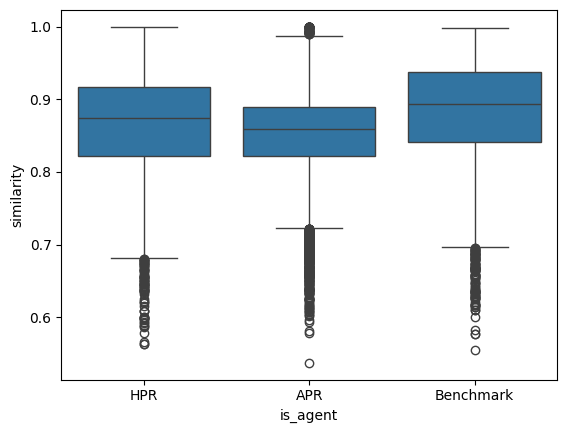

In [115]:
sns.boxplot(x='is_agent', y='similarity', data=boxplot_df)
plt.show()

## Commit message vs diff

In [116]:
splits = {'train': 'train.csv', 'validation': 'val.csv', 'test': 'test.csv'}
df = pd.read_csv("hf://datasets/Maxscha/commitbench/" + splits["test"])

'(ReadTimeoutError("HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 1ad41b7d-b2ac-41ee-8c77-84d9c6231492)')' thrown while requesting GET https://huggingface.co/datasets/Maxscha/commitbench/resolve/main/test.csv
Retrying in 1s [Retry 1/5].


In [120]:
df.head(2)

,hash,diff,message,project,split,diff_languages
0,713a0a528e7b8ab7348d8e43d3e3aa2e234b20ab,diff --git a/Auth/OpenID/Message.php b/Auth/Op...,[project @ Fix openid.ns value],openid_php-openid,test,php
1,626e13a211c82f833ade88faabcfa104bbf6c7f6,diff --git a/salt/modules/systemd.py b/salt/mo...,fix bug from systems without any legacy init s...,saltstack_salt,test,py


In [124]:
filtered_diff_languages = df.groupby("diff_languages")['hash'].nunique().reset_index()
filtered_diff_languages = filtered_diff_languages[filtered_diff_languages['hash'] > 1000]['diff_languages'].tolist()

In [126]:
df = df[df['diff_languages'].isin(filtered_diff_languages)]

In [132]:
df_sampled = (
    df
    .groupby('diff_languages', group_keys=False)
    .apply(lambda x: x.sample(frac=0.05, random_state=42))
)


/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_25328/520233614.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=0.05, random_state=42))


In [133]:
df_sampled.shape

(12422, 6)

In [135]:
df_sampled.diff_languages.value_counts()

diff_languages
py         3294
js         2630
php        2088
rb         1539
java       1138
go          963
py,py       210
rb,rb       201
js,js       166
php,php     122
go,go        71
Name: count, dtype: int64

In [136]:
df_sampled.to_parquet(config.BENCHMARK_COMMITBENCH_DF_PATH, index=False, engine='pyarrow')

In [168]:
def load_patch_for_inference(pr_commit_details_df, human_pr_commit_details_df):
    pr_commit_details_df = pr_commit_details_df[pr_commit_details_df['patch'].isnull() == False]
    pr_commit_details_df = pr_commit_details_df[['sha', 'patch']]
    pr_commit_details_df['is_agent'] = 1
    pr_commit_details_df = pr_commit_details_df.drop_duplicates()
    pr_commit_details_df = pr_commit_details_df.sample(frac=0.05, random_state=42)

    human_pr_commit_details_df = human_pr_commit_details_df[human_pr_commit_details_df['patch'].isnull() == False]
    human_pr_commit_details_df = human_pr_commit_details_df[['sha', 'patch']]
    human_pr_commit_details_df['is_agent'] = 0
    human_pr_commit_details_df = human_pr_commit_details_df.drop_duplicates()
    human_pr_commit_details_df = human_pr_commit_details_df.sample(frac=0.05, random_state=42)

    benchmark_df = pd.read_parquet(config.BENCHMARK_COMMITBENCH_DF_PATH)
    benchmark_df = benchmark_df[['hash', 'diff']]
    benchmark_df.columns = ['sha', 'patch']
    benchmark_df['is_agent'] = 2
    benchmark_df = benchmark_df.drop_duplicates()

    df = pd.concat([pr_commit_details_df, human_pr_commit_details_df, benchmark_df], ignore_index=True)
    # combined patch by sha
    df = df.groupby(['sha', 'is_agent'])['patch'].apply(lambda x: '\n'.join(x)).reset_index()
    assert df.shape[0] == df[['sha', 'is_agent']].drop_duplicates().shape[0] # make sure unique by sha
    return df
    

In [169]:
commit_inference_df = load_patch_for_inference(pr_commit_details_df, human_pr_commit_details_df)

In [170]:
commit_inference_df.head(2)

,sha,is_agent,patch
0,00024cf148680c9d347bd6056e5233f488852923,0,"@@ -8,7 +8,6 @@\n using Microsoft.Build.Execut..."
1,00059a37e7ef6001145737a29f4e81e736111967,1,"@@ -914,7 +914,7 @@ export default class FileO..."


In [176]:
commit_inference_df.shape

(31519, 3)

In [177]:
commit_inference_df.head()

,sha,is_agent,patch
0,00024cf148680c9d347bd6056e5233f488852923,0,"@@ -8,7 +8,6 @@\n using Microsoft.Build.Execut..."
1,00059a37e7ef6001145737a29f4e81e736111967,1,"@@ -914,7 +914,7 @@ export default class FileO..."
2,0006765ca3c5641ef732bad9df58e01f05c6f19c,2,diff --git a/src/store.js b/src/store.js\ninde...
3,0009a2e6c28af5e96208a732c76f9e1e92844f71,2,diff --git a/openquake/commands/tests/commands...
4,000b7184928dbd24b35e16843c65b8f9d74d445f,2,diff --git a/release.py b/release.py\nindex <H...


In [178]:
commit_inference_df.is_agent.value_counts()

is_agent
1    14063
2    12422
0     5034
Name: count, dtype: int64

In [179]:
commit_inference_df.to_parquet(config.INFERENCE_COMMIT_MESSAGE_GENERATION_DF_PATH, index=False, engine='pyarrow')

In [194]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("JetBrains-Research/cmg-codet5-without-history")
model_gen = AutoModelForSeq2SeqLM.from_pretrained("JetBrains-Research/cmg-codet5-without-history")

def generate_commit_message(patch: str) -> str:
    inputs = tokenizer(patch, return_tensors="pt", truncation=True)
    outputs = model_gen.generate(**inputs, max_length=2000)
    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded_output

In [195]:
commit_inference_df.head()

,sha,is_agent,patch
0,00024cf148680c9d347bd6056e5233f488852923,0,"@@ -8,7 +8,6 @@\n using Microsoft.Build.Execut..."
1,00059a37e7ef6001145737a29f4e81e736111967,1,"@@ -914,7 +914,7 @@ export default class FileO..."
2,0006765ca3c5641ef732bad9df58e01f05c6f19c,2,diff --git a/src/store.js b/src/store.js\ninde...
3,0009a2e6c28af5e96208a732c76f9e1e92844f71,2,diff --git a/openquake/commands/tests/commands...
4,000b7184928dbd24b35e16843c65b8f9d74d445f,2,diff --git a/release.py b/release.py\nindex <H...


In [196]:
generate_commit_message(commit_inference_df['patch'][4])

'fix: release.py base dir'

In [190]:
commit_message_gen_result_df = pd.read_parquet(config.INFERENCE_COMMIT_MESSAGE_GENERATION_OUTPUT_DF_PATH)

In [191]:
commit_message_gen_result_df.head()

,sha,is_agent,patch,message
0,00024cf148680c9d347bd6056e5233f488852923,0,"@@ -8,7 +8,6 @@\n using Microsoft.Build.Execut...",Remove unnecessary DisallowNull
1,00059a37e7ef6001145737a29f4e81e736111967,1,"@@ -914,7 +914,7 @@ export default class FileO...",Remove override from FileOrganizer
2,0006765ca3c5641ef732bad9df58e01f05c6f19c,2,diff --git a/src/store.js b/src/store.js\ninde...,cache computed getters
3,0009a2e6c28af5e96208a732c76f9e1e92844f71,2,diff --git a/openquake/commands/tests/commands...,Add test for slow_sources
4,000b7184928dbd24b35e16843c65b8f9d74d445f,2,diff --git a/release.py b/release.py\nindex <H...,fix: release.py base dir


In [197]:
commit_message_gen_result_df = add_embeddings(commit_message_gen_result_df, 'message', 'embedding_message')

Batches:   0%|          | 0/985 [00:00<?, ?it/s]

In [204]:
def get_message_label(df: pd.DataFrame, pr_commit_details_df, human_pr_commit_details_df):
    pr_commit_details_df = pr_commit_details_df[pr_commit_details_df['patch'].isnull() == False]
    pr_commit_details_df = pr_commit_details_df[['sha', 'message']]
    pr_commit_details_df['is_agent'] = 1
    pr_commit_details_df = pr_commit_details_df.drop_duplicates()
    pr_commit_details_df.rename(columns={'message': 'label_message'}, inplace=True)

    human_pr_commit_details_df = human_pr_commit_details_df[human_pr_commit_details_df['patch'].isnull() == False]
    human_pr_commit_details_df = human_pr_commit_details_df[['sha', 'message']]
    human_pr_commit_details_df['is_agent'] = 0
    human_pr_commit_details_df = human_pr_commit_details_df.drop_duplicates()
    human_pr_commit_details_df.rename(columns={'message': 'label_message'}, inplace=True)

    benchmark_df = pd.read_parquet(config.BENCHMARK_COMMITBENCH_DF_PATH)
    benchmark_df = benchmark_df[['hash', 'message']]
    benchmark_df.columns = ['sha', 'label_message']
    benchmark_df['is_agent'] = 2
    benchmark_df = benchmark_df.drop_duplicates()

    combined_df = pd.concat([pr_commit_details_df, human_pr_commit_details_df, benchmark_df], ignore_index=True)
    assert combined_df.shape[0] == combined_df[['sha', 'is_agent']].drop_duplicates().shape[0] # make sure unique by sha
    # combined patch by sha
    df = df.merge(combined_df, on=['sha', 'is_agent'], how='left')
    assert df.shape[0] == df[['sha', 'is_agent']].drop_duplicates().shape[0] # make sure unique by sha
    return df


In [205]:
commit_message_gen_result_df = get_message_label(commit_message_gen_result_df, pr_commit_details_df, human_pr_commit_details_df)

In [206]:
commit_message_gen_result_df.head()

,sha,is_agent,patch,message,embedding_message,label_message
0,00024cf148680c9d347bd6056e5233f488852923,0,"@@ -8,7 +8,6 @@\n using Microsoft.Build.Execut...",Remove unnecessary DisallowNull,"[-0.0023385752, -0.028985387, 0.0069279578, -0...",Enable Nullable Reference Types
1,00059a37e7ef6001145737a29f4e81e736111967,1,"@@ -914,7 +914,7 @@ export default class FileO...",Remove override from FileOrganizer,"[-0.032013353, -0.05510241, 0.03010867, 4.0360...",fix: remove override keyword causing esbuild e...
2,0006765ca3c5641ef732bad9df58e01f05c6f19c,2,diff --git a/src/store.js b/src/store.js\ninde...,cache computed getters,"[-0.01325984, -0.017734429, 0.032016113, 0.019...",fix: fix getters getting re-evaluated on every...
3,0009a2e6c28af5e96208a732c76f9e1e92844f71,2,diff --git a/openquake/commands/tests/commands...,Add test for slow_sources,"[0.0045399675, -0.0133054815, 0.010903581, 0.0...",Added test on `oq show slow_sources`
4,000b7184928dbd24b35e16843c65b8f9d74d445f,2,diff --git a/release.py b/release.py\nindex <H...,fix: release.py base dir,"[-0.015803484, 0.016094852, -0.017886907, 0.01...",bug(release): fix base_dir issue


In [207]:
commit_message_gen_result_df = add_embeddings(commit_message_gen_result_df, 'label_message', 'embedding_label_message')


Batches:   0%|          | 0/985 [00:00<?, ?it/s]

In [208]:
commit_message_gen_result_df = add_similarity(commit_message_gen_result_df, 'embedding_label_message', 'embedding_message')

In [209]:
commit_message_gen_result_df.groupby('is_agent')['similarity'].describe()

,count,mean,std,min,25%,50%,75%,max
is_agent,,,,,,,,
0,5034.0,0.693483,0.087618,0.494170,0.627865,0.671656,0.748170,1.0
1,14063.0,0.720967,0.090934,0.502399,0.648252,0.704776,0.788599,1.0
2,12422.0,0.774801,0.088154,0.514806,0.708502,0.777539,0.838981,1.0


In [210]:
df_pr_sim_agg.shape

(26642, 7)

In [212]:
df_pr_sim_agg.head()

,pr_id,is_agent,message,pr_description,pr_description_embedding,message_embedding,similarity
0,2256777953,0,Bump WebKit again,Bump WebKit again ### What does this PR do?\r\...,"[0.020009177, 0.010992475, 0.027312627, 0.0015...","[-0.022720661, -0.017416628, 0.026926702, 0.00...",0.765974
1,2256824367,0,filter workspaces when installing Merge branch...,support `bun install --filter <pattern>` ### W...,"[0.043265533, 0.024298789, 0.02928542, -0.0390...","[0.012198653, 0.011022276, 0.0025873156, 0.007...",0.766970
2,2256920866,0,fix: query,fix: slow lastalert query close https://github...,"[-0.029973548, -0.02613219, 0.0478204, 0.00557...","[-0.0209959, 0.017741619, 0.01283434, 0.016133...",0.778931
4,2257021600,0,Release packages,Release packages This PR was opened by the [Ch...,"[0.0010933207, -0.024358584, 0.009111474, -0.0...","[-0.01512807, 0.022231128, 0.029756987, 0.0046...",0.822990
5,2257022379,0,Bump nunit\n\nBumps the dotnet group in /sampl...,Bump nunit from 4.3.1 to 4.3.2 in /samples/sni...,"[-0.024040632, -0.033558037, 0.024762012, -0.0...","[-0.009791438, -0.05991233, 0.031387523, -0.00...",0.935931


In [213]:
df_pr_sim_agg.similarity.describe()

count    26642.000000
mean         0.854645
std          0.057257
min          0.537043
25%          0.822474
50%          0.860621
75%          0.892415
max          1.000000
Name: similarity, dtype: float64

In [216]:
df_pr_sim_agg[df_pr_sim_agg['similarity'] >= 0.9]['is_agent'].value_counts()

is_agent
1    3902
0    1384
Name: count, dtype: int64

In [10]:
pr_commits_df[pr_commits_df['sha'] == "2f9d54dda4f0c87c19e0bbeb9936f525d0587e16"]

,sha,pr_id,author,committer,message
71336,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...


In [11]:
pr_commit_details_df.head()

,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch
0,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,.github/workflows/compile-llms-txt.yml,added,38.0,0.0,38.0,"@@ -0,0 +1,38 @@\n+name: Compile llms.txt\n+\n..."
1,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,docs/compile_llms_txt.py,added,47.0,0.0,47.0,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im..."
2,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,llms.txt,added,22923.0,0.0,22923.0,None
3,dbd1b5f129f7cffa5ce284d7255814c98bcc38a2,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Fix lint issues: remove unused variable and ap...,35,18,17,docs/compile_llms_txt.py,modified,18.0,17.0,35.0,"@@ -1,47 +1,48 @@\n import os\n from pathlib i..."
4,c2659cfdedf666c8f14753d71664563c2a932b23,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Update llms.txt to follow official standard wi...,23035,89,22946,docs/compile_llms_txt.py,modified,51.0,36.0,87.0,"@@ -3,45 +3,60 @@\n \n \n def compile_llms_txt..."


In [3]:
pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pull_request.parquet")

In [13]:
pr_df.head()

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url
0,3264933329,2911,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,Claude_Code,108661493,weiliu1031,closed,2025-07-26T02:59:01Z,2025-07-29T07:01:20Z,None,191751505,https://api.github.com/repos/milvus-io/pymilvus,https://github.com/milvus-io/pymilvus/pull/2911
1,3265118634,2,ファイルパス参照を相対パスに統一し、doc/からdocs/に統一,## 背景\n\n現在、本プロジェクトにおいて以下のパス構成の不整合が生じています：\n\n...,Claude_Code,61827001,cm-kojimat,closed,2025-07-26T04:56:55Z,2025-07-26T22:12:24Z,2025-07-26T22:12:24Z,1025472321,https://api.github.com/repos/classmethod/tsumiki,https://github.com/classmethod/tsumiki/pull/2
2,3265640341,30,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,Claude_Code,7475,MSch,closed,2025-07-26T13:31:19Z,2025-07-26T13:37:22Z,2025-07-26T13:37:22Z,988488798,https://api.github.com/repos/steipete/Peekaboo,https://github.com/steipete/Peekaboo/pull/30
3,3265709660,205,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,Claude_Code,80381,sugyan,closed,2025-07-26T14:07:22Z,2025-07-26T14:45:30Z,2025-07-26T14:45:30Z,999285986,https://api.github.com/repos/sugyan/claude-cod...,https://github.com/sugyan/claude-code-webui/pu...
4,3265782173,17625,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...,Claude_Code,47593288,adust09,open,2025-07-26T15:02:48Z,None,None,537233603,https://api.github.com/repos/paradigmxyz/reth,https://github.com/paradigmxyz/reth/pull/17625


In [14]:
pr_df.isnull().sum()/len(pr_df)

id            0.000000
number        0.000000
title         0.000000
body          0.010716
agent         0.000000
user_id       0.000000
user          0.000000
state         0.000000
created_at    0.000000
closed_at     0.068818
merged_at     0.285213
repo_id       0.000000
repo_url      0.000000
html_url      0.000000
dtype: float64

In [15]:
pr_df.title.str.len().describe()

count    33596.000000
mean        42.847393
std         18.126174
min          1.000000
25%         30.000000
50%         39.000000
75%         51.000000
max        351.000000
Name: title, dtype: float64

In [16]:
pr_df.body.str.len().describe()

count    33236.000000
mean       940.919966
std       1657.329252
min          1.000000
25%        276.000000
50%        387.000000
75%        956.000000
max      77435.000000
Name: body, dtype: float64

In [4]:
# Human-PR
human_pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/human_pull_request.parquet")
human_pr_task_type_df = pd.read_parquet("hf://datasets/hao-li/AIDev/human_pr_task_type.parquet")

In [18]:
human_pr_df.isnull().sum()/len(human_pr_df)

id            0.000000
number        0.000000
title         0.000000
user          0.000000
user_id       0.000000
state         0.000000
created_at    0.000000
closed_at     0.070867
merged_at     0.232245
repo_url      0.000000
html_url      0.000000
body          0.150348
agent         0.000000
dtype: float64

In [19]:
human_pr_df.title.str.len().describe()

count    6618.000000
mean       44.265941
std        20.592332
min         2.000000
25%        29.000000
50%        43.000000
75%        56.000000
max       389.000000
Name: title, dtype: float64

In [20]:
human_pr_df.body.str.len().describe()

count     5623.000000
mean      2136.398186
std       5656.123998
min          2.000000
25%        228.000000
50%        690.000000
75%       1873.500000
max      80113.000000
Name: body, dtype: float64

*** insights: we can see that human PRs have more missing values in the body than the agentic PRs. but human PRs description are more longer than agentic PRs. both title and body description are more longer for human PRs. At the commit level, Agentic PRs have longer commit messages than human PRs.

In [152]:
human_commit_details_df = pd.read_parquet("../data/github/output/human_pr_commit_details_part_1.parquet")
human_commit_details_df.head()

,sha,pr_id,file,status,additions,deletions,changes,patch,message,author,author_email,date
0,c5470b1f0c6a4fbfbd1847250099e1995dafde3b,2336888723,static/app/components/workflowEngine/gridCell/...,modified,14,4,18,"@@ -19,9 +19,10 @@ export type Action = keyof ...",feat(aci): add automations index page,Mia Hsu,ameliahsu@gmail.com,2025-02-14T18:38:44Z
1,c5470b1f0c6a4fbfbd1847250099e1995dafde3b,2336888723,static/app/components/workflowEngine/useBulkAc...,modified,8,8,16,"@@ -7,12 +7,12 @@ import Checkbox from 'sentry...",feat(aci): add automations index page,Mia Hsu,ameliahsu@gmail.com,2025-02-14T18:38:44Z
2,c5470b1f0c6a4fbfbd1847250099e1995dafde3b,2336888723,static/app/views/automations/components/automa...,added,158,0,158,"@@ -0,0 +1,158 @@\n+import styled from '@emoti...",feat(aci): add automations index page,Mia Hsu,ameliahsu@gmail.com,2025-02-14T18:38:44Z
3,c5470b1f0c6a4fbfbd1847250099e1995dafde3b,2336888723,static/app/views/automations/components/automa...,added,131,0,131,"@@ -0,0 +1,131 @@\n+import styled from '@emoti...",feat(aci): add automations index page,Mia Hsu,ameliahsu@gmail.com,2025-02-14T18:38:44Z
4,c5470b1f0c6a4fbfbd1847250099e1995dafde3b,2336888723,static/app/views/automations/list.tsx,modified,63,1,64,"@@ -1,27 +1,89 @@\n import {Fragment} from 're...",feat(aci): add automations index page,Mia Hsu,ameliahsu@gmail.com,2025-02-14T18:38:44Z


In [22]:
human_commit_details_df.isnull().sum()/len(human_commit_details_df)

sha             0.000000
pr_id           0.000000
file            0.000000
status          0.000000
additions       0.000000
deletions       0.000000
changes         0.000000
patch           0.084722
message         0.000000
author          0.000000
author_email    0.000000
date            0.000000
dtype: float64

In [23]:
human_commit_details_df.message.str.len().describe()

count    50270.000000
mean        68.154446
std        226.191948
min          1.000000
25%         31.000000
50%         46.000000
75%         61.000000
max      11278.000000
Name: message, dtype: float64

In [24]:
pr_commit_details_df.isnull().sum()/len(pr_commit_details_df)

sha                       0.000000
pr_id                     0.000000
author                    0.000004
committer                 0.000004
message                   0.000028
commit_stats_total        0.000000
commit_stats_additions    0.000000
commit_stats_deletions    0.000000
filename                  0.007209
status                    0.007209
additions                 0.007209
deletions                 0.007209
changes                   0.007209
patch                     0.098609
dtype: float64

In [25]:
pr_commit_details_df.message.str.len().describe()

count    711903.000000
mean        108.971217
std         454.774705
min           1.000000
25%          38.000000
50%          57.000000
75%         104.000000
max       54214.000000
Name: message, dtype: float64

In [50]:
from transformers import pipeline
import torch

text = [
    "Brevity is the soul of wit.",
    "Amor, ch'a nullo amato amar perdona."
]

model_ckpt = "papluca/xlm-roberta-base-language-detection"
device = 0 if torch.backends.mps.is_available() else -1
pipe = pipeline("text-classification", model=model_ckpt, device=device)
pipe(text, top_k=1, truncation=True)


[[{'label': 'en', 'score': 0.8889275193214417}],
 [{'label': 'it', 'score': 0.912011981010437}]]

In [ ]:
def detect_language(x):
    if not isinstance(x, str) or not x.strip():
        return None
    return pipe(x,top_k=1,truncation=True)[0]['label']

In [55]:
human_pr_df['language_used_in_body'] = human_pr_df['body'].apply(lambda x: detect_language(x))

In [56]:
human_pr_df['language_used_in_title'] = human_pr_df['title'].apply(lambda x: detect_language(x))

In [58]:
human_pr_df.language_used_in_title.value_counts()/len(human_pr_df)

language_used_in_title
en    0.837715
it    0.032940
sw    0.032336
ur    0.031429
pt    0.023874
hi    0.018586
nl    0.008311
tr    0.003324
ja    0.002720
de    0.002418
zh    0.001813
pl    0.001813
es    0.001058
bg    0.000907
fr    0.000604
ru    0.000151
Name: count, dtype: float64

In [59]:
human_pr_df.language_used_in_body.value_counts()/len(human_pr_df)

language_used_in_body
en    0.822303
ur    0.004986
hi    0.004533
ja    0.004533
zh    0.003929
sw    0.002720
it    0.001813
pt    0.001511
tr    0.001058
nl    0.000756
pl    0.000604
es    0.000453
fr    0.000151
bg    0.000151
ru    0.000151
Name: count, dtype: float64

In [64]:
human_pr_df[human_pr_df['language_used_in_body'] != human_pr_df['language_used_in_title']].iloc[0]['body']

'https://sentry-j41gpomr5.sentry.dev/automations\r\n\r\nhttps://github.com/user-attachments/assets/5bb19787-5d94-460f-9fa1-deef76049f74\r\n\r\n'

In [73]:
text = 'This is a test'

pipe(text, top_k=1, truncation=True)

[{'label': 'en', 'score': 0.9789775609970093}]

# 2.2 Building classification model

In [5]:
base_df = pr_df[['id', 'title', 'body']]
base_df.columns = ['pr_id', 'pr_title', 'pr_body']

In [6]:
base_df.head()

,pr_id,pr_title,pr_body
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...
1,3265118634,ファイルパス参照を相対パスに統一し、doc/からdocs/に統一,## 背景\n\n現在、本プロジェクトにおいて以下のパス構成の不整合が生じています：\n\n...
2,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...
3,3265709660,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...
4,3265782173,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...


In [ ]:
from transformers import pipeline
import torch

text = [
    "Brevity is the soul of wit.",
    "Amor, ch'a nullo amato amar perdona."
]

model_ckpt = "papluca/xlm-roberta-base-language-detection"
device = 0 if torch.backends.mps.is_available() else -1
pipe = pipeline("text-classification", model=model_ckpt, device=device)
pipe(text, top_k=1, truncation=True)


In [ ]:
def detect_language(x):
    if not isinstance(x, str) or not x.strip():
        return None, None
    result = pipe(x, top_k=1, truncation=True)[0]
    return result['label'], result['score']

In [163]:

def add_language_confidence(df: pd.DataFrame, column_name: str):
    df[['language', 'confidence']] = df[column_name].apply(detect_language).apply(pd.Series)
    return df

In [164]:
base_df = add_language_confidence(base_df, 'pr_body')

/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_15358/2095008140.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['language', 'confidence']] = df[column_name].apply(detect_language).apply(pd.Series)
/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_15358/2095008140.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['language', 'confidence']] = df[column_name].apply(detect_language).apply(pd.Series)


In [165]:
base_df.head()

,pr_id,pr_title,pr_body,language,confidence
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,en,0.992134
1,3265118634,ファイルパス参照を相対パスに統一し、doc/からdocs/に統一,## 背景\n\n現在、本プロジェクトにおいて以下のパス構成の不整合が生じています：\n\n...,ja,0.989274
2,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,en,0.992562
3,3265709660,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,en,0.991064
4,3265782173,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...,en,0.957770


In [ ]:
# base_df.to_parquet("/Users/dungp@backbase.com/Documents/aidev-mining/data/classification/pr_df_with_language.parquet")

In [217]:
base_df = pd.read_parquet("/Users/dungp@backbase.com/Documents/aidev-mining/data/classification/pr_df_with_language.parquet")

In [218]:
base_df.shape

(33596, 5)

In [219]:
base_df[base_df['confidence'] > 0.7].shape

(31631, 5)

In [220]:
base_df_filtered = base_df[(base_df['confidence'] > 0.7) & (base_df['language'] == 'en')]
base_df_filtered.drop(columns=['confidence', 'language'], axis=1, inplace=True)
base_df_filtered.head()

/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_25328/4239870594.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df_filtered.drop(columns=['confidence', 'language'], axis=1, inplace=True)


,pr_id,pr_title,pr_body
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...
2,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...
3,3265709660,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...
4,3265782173,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...
5,3231949586,feat(swagger): Add Swagger annotations to Batc...,## Summary\nProgressive implementation of Swag...


In [221]:
base_df_filtered.shape

(31404, 3)

In [222]:
base_df_filtered.pr_id.nunique() == base_df_filtered.shape[0]

True

In [223]:
df_pr_sim_agg.head()

,pr_id,is_agent,message,pr_description,pr_description_embedding,message_embedding,similarity
0,2256777953,0,Bump WebKit again,Bump WebKit again ### What does this PR do?\r\...,"[0.020009177, 0.010992475, 0.027312627, 0.0015...","[-0.022720661, -0.017416628, 0.026926702, 0.00...",0.765974
1,2256824367,0,filter workspaces when installing Merge branch...,support `bun install --filter <pattern>` ### W...,"[0.043265533, 0.024298789, 0.02928542, -0.0390...","[0.012198653, 0.011022276, 0.0025873156, 0.007...",0.766970
2,2256920866,0,fix: query,fix: slow lastalert query close https://github...,"[-0.029973548, -0.02613219, 0.0478204, 0.00557...","[-0.0209959, 0.017741619, 0.01283434, 0.016133...",0.778931
4,2257021600,0,Release packages,Release packages This PR was opened by the [Ch...,"[0.0010933207, -0.024358584, 0.009111474, -0.0...","[-0.01512807, 0.022231128, 0.029756987, 0.0046...",0.822990
5,2257022379,0,Bump nunit\n\nBumps the dotnet group in /sampl...,Bump nunit from 4.3.1 to 4.3.2 in /samples/sni...,"[-0.024040632, -0.033558037, 0.024762012, -0.0...","[-0.009791438, -0.05991233, 0.031387523, -0.00...",0.935931


In [231]:
def add_pr_title_length(df: pd.DataFrame, column_name: str):
    df['pr_title_length'] = df[column_name].str.len()
    return df
base_df_filtered = add_pr_title_length(base_df_filtered, 'pr_title')
base_df_filtered.head()


/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_25328/2629329127.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pr_title_length'] = df[column_name].str.len()


,pr_id,pr_title,pr_body,pr_title_length
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,75
2,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,43
3,3265709660,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,64
4,3265782173,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...,43
5,3231949586,feat(swagger): Add Swagger annotations to Batc...,## Summary\nProgressive implementation of Swag...,89


In [232]:
def add_pr_body_length(df: pd.DataFrame, column_name: str):
    df['pr_body_length'] = df[column_name].str.len()
    return df
base_df_filtered = add_pr_body_length(base_df_filtered, 'pr_body')
base_df_filtered.head()


/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_25328/3743475263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pr_body_length'] = df[column_name].str.len()


,pr_id,pr_title,pr_body,pr_title_length,pr_body_length
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,75,1928
2,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,43,4516
3,3265709660,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,64,2222
4,3265782173,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...,43,327
5,3231949586,feat(swagger): Add Swagger annotations to Batc...,## Summary\nProgressive implementation of Swag...,89,4905


In [233]:
def load_pr_task_type_df() -> pd.DataFrame:
    pr_task_type_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_task_type.parquet")
    pr_task_type_df.columns = ['agent', 'pr_id', 'title', 'reason', 'task_type', 'confidence']
    return pr_task_type_df

In [234]:
pr_task_type_df = load_pr_task_type_df()

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: e28c0848-11ee-4dba-a3ac-98d957306f00)')' thrown while requesting GET https://huggingface.co/datasets/hao-li/AIDev/resolve/main/pr_task_type.parquet
Retrying in 1s [Retry 1/5].
'(ReadTimeoutError("HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: caff3940-7670-44de-88c3-bd5abe7577d1)')' thrown while requesting GET https://huggingface.co/datasets/hao-li/AIDev/resolve/main/pr_task_type.parquet
Retrying in 2s [Retry 2/5].
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: dd3e11e8-0ad0-4f66-9d62-5ce5859bab80)')' thrown while requesting GET https://huggingface.co/datasets/hao-li/AIDev/resolve/main/pr_task_type.parquet
Retrying in 1s [Retry 1/5].
'(ReadTimeoutError("HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read 

In [235]:
pr_task_type_df.head()

,agent,pr_id,title,reason,task_type,confidence
0,Claude_Code,3264933329,Fix: Wait for all partitions in load_collectio...,title provides conventional commit label,fix,10
1,Claude_Code,3265709660,feat: add comprehensive README screenshots wit...,title provides conventional commit label,feat,10
2,Claude_Code,3265782173,chore: remove HashedPostStateProvider trait,title provides conventional commit label,chore,10
3,Claude_Code,3231949586,feat(swagger): Add Swagger annotations to Batc...,title provides conventional commit label,feat,10
4,Claude_Code,3231950376,feat(swagger): Add Swagger annotations to Batc...,title provides conventional commit label,feat,10


In [236]:
from loguru import logger

def add_pr_task_type(df: pd.DataFrame, pr_task_type_df: pd.DataFrame):
    pr_task_type_df = pr_task_type_df[['pr_id', 'task_type']]
    df = df.merge(pr_task_type_df, on='pr_id', how='left')
    logger.info(f'{df.shape[0]} rows after merging with pr_task_type_df')
    logger.info(f'task type colummn missing value: {df["task_type"].isnull().sum()}')
    return df

In [237]:
base_df_filtered = add_pr_task_type(base_df_filtered, pr_task_type_df)

2025-11-10 10:18:02.922 | INFO     | __main__:add_pr_task_type:6 - 31404 rows after merging with pr_task_type_df
2025-11-10 10:18:02.923 | INFO     | __main__:add_pr_task_type:7 - task type colummn missing value: 0


In [239]:
base_df_filtered.head()

,pr_id,pr_title,pr_body,pr_title_length,pr_body_length,task_type
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,75,1928,fix
1,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,43,4516,feat
2,3265709660,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,64,2222,feat
3,3265782173,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...,43,327,chore
4,3231949586,feat(swagger): Add Swagger annotations to Batc...,## Summary\nProgressive implementation of Swag...,89,4905,feat


In [240]:
import pandas as pd
import re

def detect_issue_task_linking(df: pd.DataFrame, column_name: str):
    """Extract valid issue/task linking phrases like 'Fixes #123', 'Closes BUG-456', etc."""
    pattern = re.compile(
        r'\b(?:closes|fixes|resolves|related to|issue links?|tickets?)'  # keyword
        r'(?:[:\s]+(?:#\d+|[A-Za-z]{2,}-\d+|[A-Za-z]+-\d+))',            # require proper issue ID format
        flags=re.IGNORECASE
    )

    df['issue_task_linking'] = (
        df[column_name]
        .astype(str)
        .apply(lambda x: "; ".join(re.findall(pattern, x)) or np.nan)
    )

    return df

In [241]:
def add_contains_issue_task_linking(df: pd.DataFrame, column_name: str):
    df = detect_issue_task_linking(df, column_name)
    df['contains_issue_task_linking'] = df['issue_task_linking'].notna()
    df.drop(columns=['issue_task_linking'], axis=1, inplace=True)
    return df

In [242]:
base_df_filtered = add_contains_issue_task_linking(base_df_filtered, 'pr_body')

In [243]:
def detect_common_template_heading(df: pd.DataFrame, column_name: str):
    pattern = re.compile(
    r'(?m)^(?:#+\s*|\s*|:)?(Description|Summary|Motivation|Context|Testing Steps|How to Test|Validation|Checklist|To-Do|Screenshots)\b',
    flags=re.IGNORECASE)

    df['common_template_heading'] = (
        df[column_name]
        .astype(str)
        .apply(lambda x: "; ".join(re.findall(pattern, x)) or np.nan)
    )
    return df

In [244]:
def add_common_template_heading_score(df: pd.DataFrame, column_name: str):
    """Extract common template headings, compute global max list length,
    and assign normalized score (0 if NaN or empty)."""
    df = df.copy()
    
    df = detect_common_template_heading(df, column_name)

    # Create list of unique headings
    df['common_template_heading_list'] = df['common_template_heading'].apply(
        lambda x: list(set(x.split('; '))) if isinstance(x, str) and x.strip() else []
    )

    df['common_template_heading_length'] = df['common_template_heading_list'].apply(len)

    # Compute global max
    max_len = df['common_template_heading_length'].max() or 1
    logger.info(f'max length of common template heading: {max_len}')

    # Compute score for each row
    df['common_template_heading_score'] = df['common_template_heading_length'].apply(
        lambda x: x / max_len if x else 0
    )

    df.drop(columns=['common_template_heading', 'common_template_heading_list', 'common_template_heading_length'], axis=1, inplace=True)

    return df

In [245]:
base_df_filtered.head()

,pr_id,pr_title,pr_body,pr_title_length,pr_body_length,task_type,contains_issue_task_linking
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,75,1928,fix,False
1,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,43,4516,feat,False
2,3265709660,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,64,2222,feat,False
3,3265782173,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...,43,327,chore,False
4,3231949586,feat(swagger): Add Swagger annotations to Batc...,## Summary\nProgressive implementation of Swag...,89,4905,feat,False


In [246]:
base_df_filtered = add_common_template_heading_score(base_df_filtered, 'pr_body')

2025-11-10 10:18:20.955 | INFO     | __main__:add_common_template_heading_score:17 - max length of common template heading: 4


In [247]:
base_df_filtered.head()

,pr_id,pr_title,pr_body,pr_title_length,pr_body_length,task_type,contains_issue_task_linking,common_template_heading_score
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,75,1928,fix,False,0.25
1,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,43,4516,feat,False,0.25
2,3265709660,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,64,2222,feat,False,0.50
3,3265782173,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...,43,327,chore,False,0.25
4,3231949586,feat(swagger): Add Swagger annotations to Batc...,## Summary\nProgressive implementation of Swag...,89,4905,feat,False,0.25


In [248]:
import pandas as pd
import re

def detect_checklist_items(df: pd.DataFrame, column_name: str):
    """Detect checklist items like '- [ ]', '* [x]', or '[ ]' in text."""
    df = df.copy()
    pattern = r'^[\s*]*[-*]?\s*\[[xX\s]\]'
    df['checklist_items'] = df[column_name].apply(
        lambda x: '; '.join(re.findall(pattern, x, flags=re.MULTILINE)) if isinstance(x, str) else np.nan
    )
    return df


def add_contains_checklist_items(df: pd.DataFrame, column_name: str):
    df = df.copy()
    df = detect_checklist_items(df, column_name)
    df['contains_checklist_items'] = df['checklist_items'].notna()
    df.drop(columns=['checklist_items'], axis=1, inplace=True)
    return df

In [249]:
base_df_filtered = add_contains_checklist_items(base_df_filtered, 'pr_body')

In [250]:
def add_total_score_for_pr_template(df: pd.DataFrame):
    df = df.copy()
    df['pr_template_total_score'] = df['contains_issue_task_linking'] + df['common_template_heading_score'] + df['contains_checklist_items']
    return df

In [251]:
base_df_filtered = add_total_score_for_pr_template(base_df_filtered)

In [252]:
base_df_filtered.head()

,pr_id,pr_title,pr_body,pr_title_length,pr_body_length,task_type,contains_issue_task_linking,common_template_heading_score,contains_checklist_items,pr_template_total_score
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,75,1928,fix,False,0.25,True,1.25
1,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,43,4516,feat,False,0.25,True,1.25
2,3265709660,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,64,2222,feat,False,0.50,True,1.50
3,3265782173,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...,43,327,chore,False,0.25,True,1.25
4,3231949586,feat(swagger): Add Swagger annotations to Batc...,## Summary\nProgressive implementation of Swag...,89,4905,feat,False,0.25,True,1.25


In [253]:
def extract_code_snippets(df: pd.DataFrame, column_name: str):
    """Extract only code content from fenced code blocks (``` ... ```)."""
    df = df.copy()
    pattern = re.compile(r'```(?:\w*)\s*([\s\S]*?)```', flags=re.DOTALL)
    df['code_snippets'] = df[column_name].apply(
        lambda x: [code.strip() for code in pattern.findall(x)] if isinstance(x, str) else []
    )
    return df

def add_code_snippets_length_ratio(df: pd.DataFrame, column_name: str):
    df = df.copy()
    df = extract_code_snippets(df, column_name)
    df['code_snippets_length_ratio'] = df['code_snippets'].str.len() / df['pr_body_length']
    df.drop(columns=['code_snippets'], axis=1, inplace=True)
    logger.info(f'shape after extracting code snippets: {df.shape}')
    return df

def add_contains_code_snippets(df: pd.DataFrame, column_name: str):
    '''because the ratio is so small, transform as binary instead'''
    df = df.copy()
    df = extract_code_snippets(df, column_name)
    df['contains_code_snippets'] = df['code_snippets'].str.len() > 0
    df.drop(columns=['code_snippets'], axis=1, inplace=True)
    return df

In [254]:
base_df_filtered = add_contains_code_snippets(base_df_filtered, 'pr_body')

In [255]:
base_df_filtered.head()

,pr_id,pr_title,pr_body,pr_title_length,pr_body_length,task_type,contains_issue_task_linking,common_template_heading_score,contains_checklist_items,pr_template_total_score,contains_code_snippets
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,75,1928,fix,False,0.25,True,1.25,False
1,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,43,4516,feat,False,0.25,True,1.25,True
2,3265709660,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,64,2222,feat,False,0.50,True,1.50,False
3,3265782173,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...,43,327,chore,False,0.25,True,1.25,False
4,3231949586,feat(swagger): Add Swagger annotations to Batc...,## Summary\nProgressive implementation of Swag...,89,4905,feat,False,0.25,True,1.25,True


In [256]:
related_issue_df = pd.read_parquet("hf://datasets/hao-li/AIDev/related_issue.parquet")
issue_df = pd.read_parquet("hf://datasets/hao-li/AIDev/issue.parquet")

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 8218ac43-5f10-4af7-a91f-e05fe70250a3)')' thrown while requesting GET https://huggingface.co/datasets/hao-li/AIDev/resolve/main/related_issue.parquet
Retrying in 1s [Retry 1/5].
'(ReadTimeoutError("HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: ae6ffb20-eb6a-49f5-8e08-62007fe3831c)')' thrown while requesting GET https://huggingface.co/datasets/hao-li/AIDev/resolve/main/related_issue.parquet
Retrying in 2s [Retry 2/5].


In [257]:
def load_related_issue_df() -> pd.DataFrame:
    related_issue_df = pd.read_parquet("hf://datasets/hao-li/AIDev/related_issue.parquet")
    return related_issue_df

In [258]:
def add_number_of_related_issues(df: pd.DataFrame):
    df = df.copy()
    releated_issue_df = load_related_issue_df()
    grp = releated_issue_df.groupby('pr_id')['issue_id'].count().reset_index()
    grp.columns = ['pr_id', 'number_of_related_issues']
    df = df.merge(grp, on='pr_id', how='left')
    logger.info(f'shape after merging with related issue: {df.shape}')
    logger.info(f'percentage of related issues missing value: {df["number_of_related_issues"].isnull().sum()/df.shape[0]}')
    return df

In [259]:
base_df_filtered = add_number_of_related_issues(base_df_filtered)

2025-11-10 10:19:56.021 | INFO     | __main__:add_number_of_related_issues:7 - shape after merging with related issue: (31404, 12)
2025-11-10 10:19:56.022 | INFO     | __main__:add_number_of_related_issues:8 - percentage of related issues missing value: 0.84613425041396


In [260]:
base_df_filtered.head()

,pr_id,pr_title,pr_body,pr_title_length,pr_body_length,task_type,contains_issue_task_linking,common_template_heading_score,contains_checklist_items,pr_template_total_score,contains_code_snippets,number_of_related_issues
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,75,1928,fix,False,0.25,True,1.25,False,NaN
1,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,43,4516,feat,False,0.25,True,1.25,True,NaN
2,3265709660,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,64,2222,feat,False,0.50,True,1.50,False,NaN
3,3265782173,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...,43,327,chore,False,0.25,True,1.25,False,NaN
4,3231949586,feat(swagger): Add Swagger annotations to Batc...,## Summary\nProgressive implementation of Swag...,89,4905,feat,False,0.25,True,1.25,True,NaN


In [261]:
def load_pr_commits_df() -> pd.DataFrame:
    pr_commits_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_commits.parquet")
    return pr_commits_df

In [262]:
pr_commits_df.head()

,sha,pr_id,author,committer,message
0,15a543882cbad0c9348640cffdd71fb71ac34953,3205734508,rubys,rubys,refactor: Convert Build.Compose from string to...
1,cdd9bab35891037692f1d201db37d34d48342332,3107321792,haasonsaas,haasonsaas,Fix Windows compatibility issues in shell exec...
2,219323e2aa1dacd76a422ad24cabf6976c9a6ac0,3107321792,haasonsaas,haasonsaas,Add Windows path validation fixes and comprehe...
3,58c52841e96e9fdcb70befadf7b3994519834861,3107321792,haasonsaas,haasonsaas,Address CodeRabbit review feedback - fix criti...
4,b04470fe6bae5e6802f1fe83e7c5f0b9273e74a3,3107321792,haasonsaas,haasonsaas,Fix Windows compatibility tests - address patt...


In [263]:
def add_number_of_commits(df: pd.DataFrame):
    df = df.copy()
    pr_commits_df = load_pr_commits_df()
    grp = pr_commits_df.groupby('pr_id')['sha'].count().reset_index()
    grp.columns = ['pr_id', 'number_of_commits']
    df = df.merge(grp, on='pr_id', how='left')
    logger.info(f'shape after merging with pr_commits_df: {df.shape}')
    return df


def add_avg_commit_message_length(df: pd.DataFrame):
    df = df.copy()
    pr_commits_df = load_pr_commits_df()
    pr_commits_df = pr_commits_df[pr_commits_df['message'].isnull() == False]
    grp = pr_commits_df.groupby('pr_id').agg({'message': ' '.join}).reset_index()
    grp.columns = ['pr_id', 'commit_messages']
    df = df.merge(grp, on='pr_id', how='left')
    df['avg_commit_message_length'] = df['commit_messages'].str.len() / df['number_of_commits']
    df.drop(columns=['commit_messages'], axis=1, inplace=True)
    logger.info(f'shape after merging with pr_commits_df: {df.shape}')
    logger.info(f'percentage of commit messages missing value: {df["avg_commit_message_length"].isnull().sum()/df.shape[0]}')
    return df

In [264]:
base_df_filtered = add_number_of_commits(base_df_filtered)

2025-11-10 10:20:03.014 | INFO     | __main__:add_number_of_commits:7 - shape after merging with pr_commits_df: (31404, 13)


In [265]:
base_df_filtered = add_avg_commit_message_length(base_df_filtered)
base_df_filtered.head()

2025-11-10 10:20:05.997 | INFO     | __main__:add_avg_commit_message_length:20 - shape after merging with pr_commits_df: (31404, 14)
2025-11-10 10:20:05.998 | INFO     | __main__:add_avg_commit_message_length:21 - percentage of commit messages missing value: 0.0004776461597248758


,pr_id,pr_title,pr_body,pr_title_length,pr_body_length,task_type,contains_issue_task_linking,common_template_heading_score,contains_checklist_items,pr_template_total_score,contains_code_snippets,number_of_related_issues,number_of_commits,avg_commit_message_length
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,75,1928,fix,False,0.25,True,1.25,False,NaN,1.0,1030.000000
1,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,43,4516,feat,False,0.25,True,1.25,True,NaN,6.0,228.666667
2,3265709660,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,64,2222,feat,False,0.50,True,1.50,False,NaN,3.0,1036.000000
3,3265782173,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...,43,327,chore,False,0.25,True,1.25,False,NaN,1.0,36.000000
4,3231949586,feat(swagger): Add Swagger annotations to Batc...,## Summary\nProgressive implementation of Swag...,89,4905,feat,False,0.25,True,1.25,True,NaN,1.0,17.000000


In [266]:
pr_commit_details_df.head()

,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch
0,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,.github/workflows/compile-llms-txt.yml,added,38.0,0.0,38.0,"@@ -0,0 +1,38 @@\n+name: Compile llms.txt\n+\n..."
1,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,docs/compile_llms_txt.py,added,47.0,0.0,47.0,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im..."
2,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,llms.txt,added,22923.0,0.0,22923.0,None
3,dbd1b5f129f7cffa5ce284d7255814c98bcc38a2,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Fix lint issues: remove unused variable and ap...,35,18,17,docs/compile_llms_txt.py,modified,18.0,17.0,35.0,"@@ -1,47 +1,48 @@\n import os\n from pathlib i..."
4,c2659cfdedf666c8f14753d71664563c2a932b23,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Update llms.txt to follow official standard wi...,23035,89,22946,docs/compile_llms_txt.py,modified,51.0,36.0,87.0,"@@ -3,45 +3,60 @@\n \n \n def compile_llms_txt..."


In [267]:
def add_number_of_files_changed(df: pd.DataFrame, pr_commits_details_df: pd.DataFrame):
    df = df.copy()
    grp = pr_commits_details_df.groupby('pr_id')['filename'].nunique().reset_index()
    grp.columns = ['pr_id', 'number_of_files_changed']
    df = df.merge(grp, on='pr_id', how='left')
    return df

def add_commit_stats(df: pd.DataFrame, pr_commits_details_df: pd.DataFrame):
    df = df.copy()
    grp = pr_commits_details_df.groupby('pr_id').agg({'additions': 'sum', 'deletions': 'sum', 'changes': 'sum'}).reset_index()
    grp.columns = ['pr_id', 'total_addition', 'total_deletion', 'total_changes']
    df = df.merge(grp, on='pr_id', how='left')
    return df


def add_number_of_files_by_change_status(df: pd.DataFrame, pr_commits_details_df: pd.DataFrame):
    df = df.copy()
    grp = pr_commits_details_df.groupby(['pr_id', 'status'])['filename'].nunique().reset_index()
    grp.columns = ['pr_id', 'status', 'number_of_files']
    grp = grp.pivot(index='pr_id', columns='status', values='number_of_files').reset_index()
    df = df.merge(grp, on='pr_id', how='left')
    return df

In [268]:
pr_commit_details_df.head(2)


,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch
0,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,.github/workflows/compile-llms-txt.yml,added,38.0,0.0,38.0,"@@ -0,0 +1,38 @@\n+name: Compile llms.txt\n+\n..."
1,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,docs/compile_llms_txt.py,added,47.0,0.0,47.0,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im..."


In [269]:
base_df_filtered_add_commits = add_number_of_files_changed(base_df_filtered, pr_commit_details_df)

In [270]:
base_df_filtered_add_commits = add_commit_stats(base_df_filtered_add_commits, pr_commit_details_df)

In [271]:
base_df_filtered_add_commits = add_number_of_files_by_change_status(base_df_filtered_add_commits, pr_commit_details_df)

In [272]:
base_df_filtered_add_commits.head()

,pr_id,pr_title,pr_body,pr_title_length,pr_body_length,task_type,contains_issue_task_linking,common_template_heading_score,contains_checklist_items,pr_template_total_score,...,number_of_commits,avg_commit_message_length,number_of_files_changed,total_addition,total_deletion,total_changes,added,modified,removed,renamed
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,75,1928,fix,False,0.25,True,1.25,...,1.0,1030.000000,3.0,394.0,2.0,396.0,1.0,2.0,NaN,NaN
1,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,43,4516,feat,False,0.25,True,1.25,...,6.0,228.666667,5.0,298.0,109.0,407.0,1.0,4.0,NaN,NaN
2,3265709660,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,64,2222,feat,False,0.50,True,1.50,...,3.0,1036.000000,15.0,288.0,12.0,300.0,13.0,4.0,NaN,NaN
3,3265782173,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...,43,327,chore,False,0.25,True,1.25,...,1.0,36.000000,21.0,53.0,168.0,221.0,NaN,21.0,NaN,NaN
4,3231949586,feat(swagger): Add Swagger annotations to Batc...,## Summary\nProgressive implementation of Swag...,89,4905,feat,False,0.25,True,1.25,...,1.0,17.000000,25.0,2702.0,545.0,3247.0,1.0,24.0,NaN,NaN


In [273]:
def add_number_of_modules_l1_changed(df: pd.DataFrame, pr_commits_details_df: pd.DataFrame):
    df = df.copy()
    spread_df = pr_commits_details_df[['pr_id', 'filename']]
    spread_df['module'] = spread_df['filename'].str.split('/')
    condition = spread_df['module'].str.len() >= 2
    spread_df['spread_up_1_level'] = np.nan
    spread_df.loc[condition, 'spread_up_1_level'] = spread_df.loc[condition, 'module'].str[-2]
    grp = spread_df.groupby('pr_id')['spread_up_1_level'].nunique().reset_index()
    grp.columns = ['pr_id', 'number_of_modules_l1_changed']
    df = df.merge(grp, on='pr_id', how='left')
    return df


def add_number_of_modules_l2_changed(df: pd.DataFrame, pr_commits_details_df: pd.DataFrame):
    df = df.copy()
    spread_df = pr_commits_details_df[['pr_id', 'filename']]
    spread_df['module'] = spread_df['filename'].str.split('/')
    condition = spread_df['module'].str.len() >= 3
    spread_df['spread_up_2_level'] = np.nan
    spread_df.loc[condition, 'spread_up_2_level'] = spread_df.loc[condition, 'module'].str[-3]
    grp = spread_df.groupby('pr_id')['spread_up_2_level'].nunique().reset_index()
    grp.columns = ['pr_id', 'number_of_modules_l2_changed']
    df = df.merge(grp, on='pr_id', how='left')
    return df

In [274]:
base_df_filtered_add_commits = add_number_of_modules_l1_changed(base_df_filtered_add_commits, pr_commit_details_df)
base_df_filtered_add_commits = add_number_of_modules_l2_changed(base_df_filtered_add_commits, pr_commit_details_df)

/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_25328/264109511.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spread_df['module'] = spread_df['filename'].str.split('/')
/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_25328/264109511.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spread_df['spread_up_1_level'] = np.nan
/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_25328/264109511.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will ra

## Mark label 

In [276]:
base_df_filtered_add_commits.head()

,pr_id,pr_title,pr_body,pr_title_length,pr_body_length,task_type,contains_issue_task_linking,common_template_heading_score,contains_checklist_items,pr_template_total_score,...,number_of_files_changed,total_addition,total_deletion,total_changes,added,modified,removed,renamed,number_of_modules_l1_changed,number_of_modules_l2_changed
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,75,1928,fix,False,0.25,True,1.25,...,3.0,394.0,2.0,396.0,1.0,2.0,NaN,NaN,2.0,1.0
1,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,43,4516,feat,False,0.25,True,1.25,...,5.0,298.0,109.0,407.0,1.0,4.0,NaN,NaN,2.0,1.0
2,3265709660,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,64,2222,feat,False,0.50,True,1.50,...,15.0,288.0,12.0,300.0,13.0,4.0,NaN,NaN,3.0,2.0
3,3265782173,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...,43,327,chore,False,0.25,True,1.25,...,21.0,53.0,168.0,221.0,NaN,21.0,NaN,NaN,8.0,9.0
4,3231949586,feat(swagger): Add Swagger annotations to Batc...,## Summary\nProgressive implementation of Swag...,89,4905,feat,False,0.25,True,1.25,...,25.0,2702.0,545.0,3247.0,1.0,24.0,NaN,NaN,15.0,6.0


In [277]:
base_df_filtered_add_commits['pr_id'].nunique()

31404

In [287]:
def load_label(base_df_filtered, df_pr_sim_agg):
    base_df_filtered = base_df_filtered.merge(df_pr_sim_agg[['pr_id', 'similarity']], on='pr_id', how='inner')
    return base_df_filtered
train_df = load_label(base_df_filtered_add_commits, df_pr_sim_agg)

train_df['label'] = train_df['similarity'].apply(lambda x: 1 if x >= 0.9 else 0)
train_df.drop(columns=['pr_title','pr_body', 'similarity'], axis=1, inplace=True)

In [288]:
train_df.head()

,pr_id,pr_title_length,pr_body_length,task_type,contains_issue_task_linking,common_template_heading_score,contains_checklist_items,pr_template_total_score,contains_code_snippets,number_of_related_issues,...,total_addition,total_deletion,total_changes,added,modified,removed,renamed,number_of_modules_l1_changed,number_of_modules_l2_changed,label
0,3265640341,43,4516,feat,False,0.25,True,1.25,True,NaN,...,298.0,109.0,407.0,1.0,4.0,NaN,NaN,2.0,1.0,1
1,3265709660,64,2222,feat,False,0.50,True,1.50,False,NaN,...,288.0,12.0,300.0,13.0,4.0,NaN,NaN,3.0,2.0,1
2,3214555104,47,4869,feat,False,0.00,True,1.00,True,NaN,...,620.0,0.0,620.0,2.0,1.0,NaN,NaN,2.0,2.0,0
3,3214724259,54,1613,feat,False,0.25,True,1.25,False,NaN,...,1013.0,340.0,1353.0,NaN,6.0,NaN,NaN,4.0,2.0,0
4,3214782537,81,52264,refactor,True,0.25,True,2.25,True,1.0,...,1725.0,1103.0,2828.0,7.0,55.0,2.0,9.0,31.0,16.0,0


In [136]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Path to your checkpoint
checkpoint_path = "../models/bart/"

# Load tokenizer and model from the checkpoint
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint_path)

# Example input
input_text = "ファイルパス参照を相対パスに統一し、doc/からdocs/に統一"
inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=1024)

# Generate predictions
outputs = model.generate(**inputs, max_length=1024)
decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Prediction:", decoded_output)

Prediction: ファイルパス参照を相対パスに統一し、doc/からdocs/に�ñ一


In [140]:
pr_commits_df.head()

,sha,pr_id,author,committer,message
0,15a543882cbad0c9348640cffdd71fb71ac34953,3205734508,rubys,rubys,refactor: Convert Build.Compose from string to...
1,cdd9bab35891037692f1d201db37d34d48342332,3107321792,haasonsaas,haasonsaas,Fix Windows compatibility issues in shell exec...
2,219323e2aa1dacd76a422ad24cabf6976c9a6ac0,3107321792,haasonsaas,haasonsaas,Add Windows path validation fixes and comprehe...
3,58c52841e96e9fdcb70befadf7b3994519834861,3107321792,haasonsaas,haasonsaas,Address CodeRabbit review feedback - fix criti...
4,b04470fe6bae5e6802f1fe83e7c5f0b9273e74a3,3107321792,haasonsaas,haasonsaas,Fix Windows compatibility tests - address patt...


In [56]:
pr_df_ana = pr_commits_df[pr_commits_df['message'].isnull() == False]
pr_df_ana = pr_df_ana.groupby('pr_id').agg({'message': ' '.join}).reset_index()
pr_df_ana.columns = ['pr_id', 'aggregated_commit_messages']

In [57]:
pr_df_ana.shape

(33580, 2)

In [165]:
pr_df_ana.head()

,pr_id,aggregated_commit_messages
0,2756921963,Add integration tests for additional LLM provi...
1,2757103560,feat: add encryptStringAsync and migrate calls...
2,2757124156,docs: add consistent spacing in license sectio...
3,2757125491,docs: add emphasis to code of conduct instruct...
4,2757179026,test: Git integration tests Actual test defini...


In [166]:
pr_df_ana.shape

(33580, 2)

In [ ]:
# pr_df_ana.to_csv("/Users/dungp@backbase.com/Documents/aidev-mining/data/inference/input/pr_df_commit_messages.csv", index=False)

In [58]:
bart_inference_output = pd.read_parquet("/Users/dungp@backbase.com/Documents/aidev-mining/data/inference/output/pr_df_pr_desc.parquet")

In [59]:
bart_inference_output.head()

,pr_id,aggregated_commit_messages,bart_gen_pr_description
0,2756921963,Add integration tests for additional LLM provi...,add integration tests for additional LLM provi...
1,2757103560,feat: add encryptStringAsync and migrate calls...,add encryptStringAsync and migrate calls to as...
2,2757124156,docs: add consistent spacing in license sectio...,add consistent spacing in license section.
3,2757125491,docs: add emphasis to code of conduct instruct...,add emphasis to code of conduct instructions i...
4,2757179026,test: Git integration tests Actual test defini...,what this pr does / why we need it: adds impor...


In [188]:
from bert_score import score
from tqdm import tqdm

def compute_bertscore_pair(row, cand_col="candidate", ref_col="reference",
                           lang="en", model_type="microsoft/deberta-xlarge-mnli",
                           rescale_with_baseline=True):
    """
    Compute BERTScore for a single row.
    """
    cand = row[cand_col]
    ref = row[ref_col]
    device = torch.device("mps")
    if not isinstance(cand, str) or not cand.strip():
        return None, None, None
    if not isinstance(ref, str) or not ref.strip():
        return None, None, None

    P, R, F1 = score([cand], [ref], lang=lang,
                     rescale_with_baseline=rescale_with_baseline,
                     model_type=model_type, device=device)
    return P.item(), R.item(), F1.item()

def add_bertscore_columns(df: pd.DataFrame, cand_col="candidate", ref_col="reference"):
    """
    Add precision, recall, f1 columns to the DataFrame.
    Uses tqdm to show progress.
    """
    results = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Calculating BERTScore"):
        results.append(compute_bertscore_pair(row, cand_col, ref_col))
    
    df[['precision', 'recall', 'f1']] = pd.DataFrame(results, index=df.index)
    return df

In [60]:
df = base_df_filtered_add_commits.merge(bart_inference_output[['pr_id', 'bart_gen_pr_description']], on='pr_id', how='left')

In [61]:
df = df[df['bart_gen_pr_description'].isnull() == False]

In [65]:
df.head(2)

,pr_id,pr_title,pr_body,pr_title_length,pr_body_length,task_type,contains_issue_task_linking,common_template_heading_score,contains_checklist_items,pr_template_total_score,...,total_addition,total_deletion,total_changes,added,modified,removed,renamed,number_of_modules_l1_changed,number_of_modules_l2_changed,bart_gen_pr_description
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,75,1928,fix,False,0.25,True,1.25,...,394.0,2.0,396.0,1.0,2.0,NaN,NaN,2.0,1.0,when load_collection is called on a collection...
1,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,43,4516,feat,False,0.25,True,1.25,...,298.0,109.0,407.0,1.0,4.0,NaN,NaN,2.0,1.0,add build staleness detection for debug CLI\t-...


In [63]:
df.to_parquet("/Users/dungp@backbase.com/Documents/aidev-mining/data/inference/input/input_to_bertscore.parquet")

In [64]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load your embedding model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Function to convert a column of texts to embeddings
def add_embeddings(df, text_col, embedding_col):
    """
    Adds a column of embeddings for the given text column.
    """
    embeddings = model.encode(df[text_col].tolist())
    df[embedding_col] = list(embeddings)
    return df

# Function to compute row-wise cosine similarity between two embedding columns
def add_similarity(df, emb_col1, emb_col2, sim_col='similarity'):
    """
    Computes cosine similarity row-wise between two embedding columns.
    """
    similarities = np.array([
        cosine_similarity(e1.reshape(1, -1), e2.reshape(1, -1))[0][0]
        for e1, e2 in zip(df[emb_col1], df[emb_col2])
    ])
    df[sim_col] = similarities
    return df

In [66]:
df = add_embeddings(df, 'pr_body', 'pr_body_embedding')

In [69]:
df = add_embeddings(df, 'bart_gen_pr_description', 'bart_gen_pr_description_embedding')

In [70]:
df = add_similarity(df, 'pr_body_embedding', 'bart_gen_pr_description_embedding', 'cosine_similarity')

In [71]:
df.head()

,pr_id,pr_title,pr_body,pr_title_length,pr_body_length,task_type,contains_issue_task_linking,common_template_heading_score,contains_checklist_items,pr_template_total_score,...,added,modified,removed,renamed,number_of_modules_l1_changed,number_of_modules_l2_changed,bart_gen_pr_description,pr_body_embedding,bart_gen_pr_description_embedding,cosine_similarity
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,75,1928,fix,False,0.25,True,1.25,...,1.0,2.0,NaN,NaN,2.0,1.0,when load_collection is called on a collection...,"[-0.059493396, 0.029084722, 0.009636886, 0.037...","[-0.037949167, 0.061905406, 0.0011726056, 0.03...",0.789315
1,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,43,4516,feat,False,0.25,True,1.25,...,1.0,4.0,NaN,NaN,2.0,1.0,add build staleness detection for debug CLI\t-...,"[-0.038698785, -0.06703829, 0.003016532, 0.017...","[-0.012546122, -0.07021722, 0.00720961, -0.018...",0.869961
2,3265709660,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,64,2222,feat,False,0.50,True,1.50,...,13.0,4.0,NaN,NaN,3.0,2.0,summary Summary\t- Add professional desktop an...,"[-0.101509, 0.014655563, 0.021182679, -0.00243...","[-0.060698263, 0.06607176, 0.021556258, -0.039...",0.645019
3,3265782173,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...,43,327,chore,False,0.25,True,1.25,...,NaN,21.0,NaN,NaN,8.0,9.0,remove the trait that was removed in #1177.,"[-0.06498095, 0.04315981, -0.021561326, 0.0008...","[-0.0777981, 0.07059597, 0.01549524, 0.0446802...",0.607665
4,3231949586,feat(swagger): Add Swagger annotations to Batc...,## Summary\nProgressive implementation of Swag...,89,4905,feat,False,0.25,True,1.25,...,1.0,24.0,NaN,NaN,15.0,6.0,batch 1 resources for batch 1,"[-0.0390667, 0.053458992, -0.042743172, -0.001...","[-0.065148056, -0.0082255835, -0.07293205, 0.0...",0.285726


In [ ]:
df['cosine_similarity'].describe()

count    31389.000000
mean         0.514932
std          0.168852
min         -0.167465
25%          0.407407
50%          0.525367
75%          0.633789
max          1.000000
Name: cosine_similarity, dtype: float64

In [74]:
df[df['cosine_similarity'] > 0.7].shape[0]/df.shape[0]

0.13386855267768963

In [115]:
train_df = base_df_filtered_add_commits.merge(df[['pr_id', 'cosine_similarity']], on='pr_id', how='left')

In [116]:
train_df = train_df[train_df['cosine_similarity'].isnull() == False]

## One-hot the task_type

In [289]:
train_df.isnull().sum()

pr_id                                0
pr_title_length                      0
pr_body_length                       0
task_type                            0
contains_issue_task_linking          0
common_template_heading_score        0
contains_checklist_items             0
pr_template_total_score              0
contains_code_snippets               0
number_of_related_issues         19987
number_of_commits                    0
avg_commit_message_length            0
number_of_files_changed              0
total_addition                       0
total_deletion                       0
total_changes                        0
added                            12566
modified                          1480
removed                          19582
renamed                          21262
number_of_modules_l1_changed         0
number_of_modules_l2_changed         0
label                                0
dtype: int64

In [290]:
train_df.fillna(0, inplace=True)

In [291]:
# one-hot the task_type
train_df = pd.get_dummies(train_df, columns=['task_type'])

In [292]:
train_df.head()

,pr_id,pr_title_length,pr_body_length,contains_issue_task_linking,common_template_heading_score,contains_checklist_items,pr_template_total_score,contains_code_snippets,number_of_related_issues,number_of_commits,...,task_type_ci,task_type_docs,task_type_feat,task_type_fix,task_type_other,task_type_perf,task_type_refactor,task_type_revert,task_type_style,task_type_test
0,3265640341,43,4516,False,0.25,True,1.25,True,0.0,6.0,...,False,False,True,False,False,False,False,False,False,False
1,3265709660,64,2222,False,0.50,True,1.50,False,0.0,3.0,...,False,False,True,False,False,False,False,False,False,False
2,3214555104,47,4869,False,0.00,True,1.00,True,0.0,1.0,...,False,False,True,False,False,False,False,False,False,False
3,3214724259,54,1613,False,0.25,True,1.25,False,0.0,4.0,...,False,False,True,False,False,False,False,False,False,False
4,3214782537,81,52264,True,0.25,True,2.25,True,1.0,30.0,...,False,False,False,False,False,False,True,False,False,False


In [293]:
train_df.shape

(22161, 34)

## Train model

In [294]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assume train_df is your DataFrame
# Replace 'features' with the column names of your input features
# Replace 'target' with the name of your target column
train_df.drop(columns=['pr_id'], axis=1, inplace=True)
X = train_df.drop(columns=["label"])  # features
y = train_df["label"]                 # target

# Split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf = RandomForestClassifier(random_state=42)

# Train
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.8579
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      3669
           1       0.72      0.28      0.41       764

    accuracy                           0.86      4433
   macro avg       0.80      0.63      0.66      4433
weighted avg       0.84      0.86      0.83      4433



AUC: 0.7991


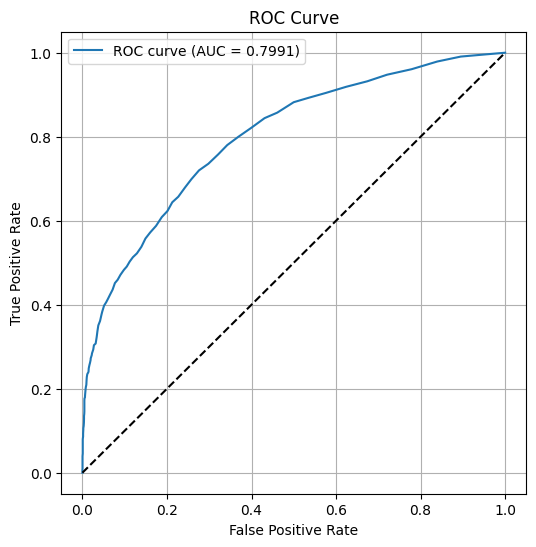

In [295]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (assuming binary classification)
y_prob = rf.predict_proba(X_test)[:, 1]

# Compute AUC
auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.4f}")

# Optional: plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line for random
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


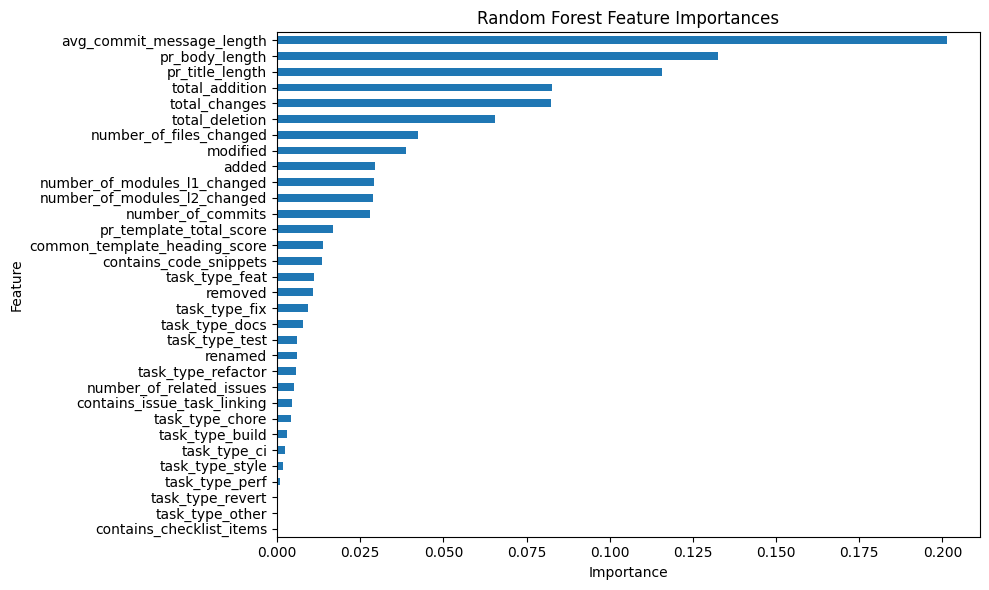

In [296]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming rf is your trained RandomForestClassifier and X_train exists
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=True)  # ascending for horizontal bar

# Plot
plt.figure(figsize=(10, 6))
feature_importances.plot(kind="barh")
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## SHAP analysis

In [ ]:
import shap

# Create explainer
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)


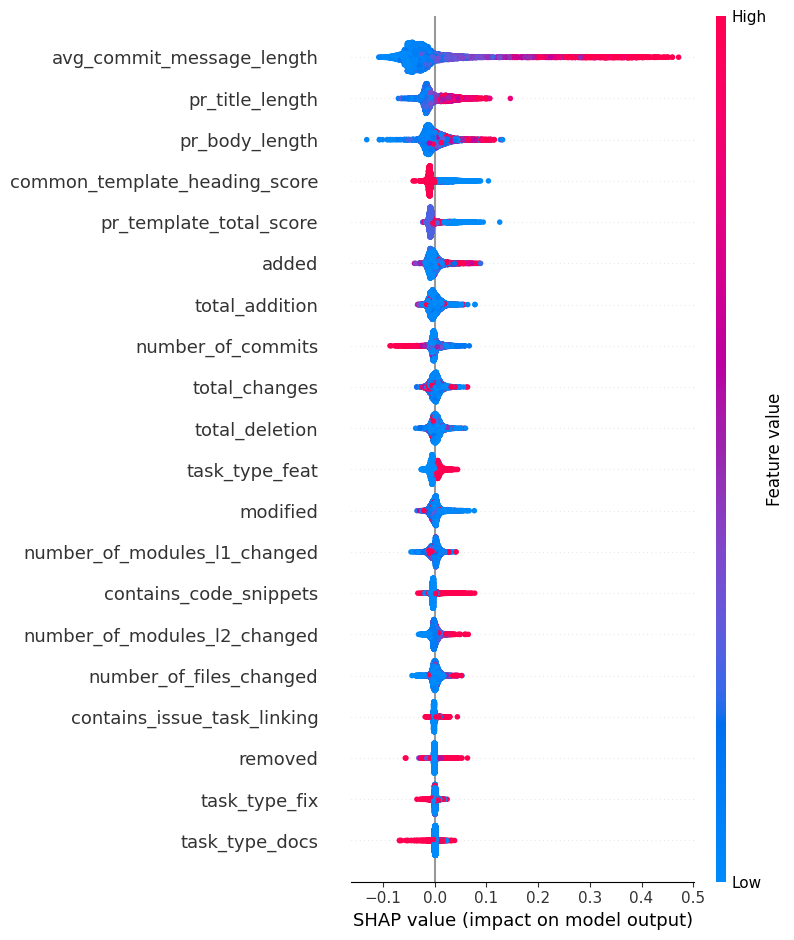

In [ ]:
# Summary plot for all features
shap.summary_plot(shap_values[:, :, 1], X_test)  # [1] for positive class in binary classification


In [129]:
shap_values[1].shape

(32, 2)

In [132]:
pr_commits_df.head()

,sha,pr_id,author,committer,message
0,15a543882cbad0c9348640cffdd71fb71ac34953,3205734508,rubys,rubys,refactor: Convert Build.Compose from string to...
1,cdd9bab35891037692f1d201db37d34d48342332,3107321792,haasonsaas,haasonsaas,Fix Windows compatibility issues in shell exec...
2,219323e2aa1dacd76a422ad24cabf6976c9a6ac0,3107321792,haasonsaas,haasonsaas,Add Windows path validation fixes and comprehe...
3,58c52841e96e9fdcb70befadf7b3994519834861,3107321792,haasonsaas,haasonsaas,Address CodeRabbit review feedback - fix criti...
4,b04470fe6bae5e6802f1fe83e7c5f0b9273e74a3,3107321792,haasonsaas,haasonsaas,Fix Windows compatibility tests - address patt...


In [133]:
pr_commits_df.author.value_counts()

author
Copilot                      18884
devin-ai-integration[bot]    17080
tamnd                         8989
MontrealAI                    3674
cursoragent                   3611
                             ...  
dvj1988                          1
aryairani                        1
LinuxDroidMaster                 1
thomasxm                         1
rubys                            1
Name: count, Length: 2781, dtype: int64

In [ ]:
related_issue_df = pd.read_parquet("hf://datasets/hao-li/AIDev/related_issue.parquet")
issue_df = pd.read_parquet("hf://datasets/hao-li/AIDev/issue.parquet")

In [135]:
issue_df.head()

,id,number,title,body,user,state,created_at,closed_at,html_url
0,3082498013,1542,Accept api_key in from_provider,**Is your feature request related to a problem...,jeroenvds,closed,2025-05-22T08:22:22Z,2025-07-17T22:34:21Z,https://github.com/567-labs/instructor/issues/...
1,3164229012,94,Workflows Coming Soon - tools reimagined,### Project Version\n\n5.5.0\n\n### Bug Descri...,guidedways,closed,2025-06-20T19:42:16Z,2025-06-20T20:08:12Z,https://github.com/BeehiveInnovations/zen-mcp-...
2,3198054361,107,[bug]PromptX工具沙箱缓存机制不支持工具集更新,"当工具集需要改进的时候, 会遇到改进后代码和沙箱中的代码不一致的情况.对鲁班自己调试代码造成...",simonfishgit,closed,2025-07-03T05:20:38Z,2025-07-10T01:44:56Z,https://github.com/Deepractice/PromptX/issues/107
3,3208181218,129,架构优化：统一项目路径管理体系 - 合并DirectoryService与ProjectMa...,# 🎯 架构优化：统一项目路径管理体系\n\n## 🔍 问题描述\n\n当前PromptX在...,deepracticexs,closed,2025-07-07T09:12:24Z,2025-07-07T11:05:45Z,https://github.com/Deepractice/PromptX/issues/129
4,2975033421,836,Broken links to notebooks in documentation,On [this documentation page](https://incatools...,justaddcoffee,closed,2025-04-06T15:46:33Z,2025-06-05T23:32:27Z,https://github.com/INCATools/ontology-access-k...


In [137]:
repo_df = pd.read_parquet("hf://datasets/hao-li/AIDev/repository.parquet")
user_df = pd.read_parquet("hf://datasets/hao-li/AIDev/user.parquet")

In [138]:
user_df.head()

,id,login,followers,following,created_at
0,108661493,weiliu1031,4.0,11.0,2022-07-04T08:56:20Z
1,61827001,cm-kojimat,2.0,4.0,2020-03-05T10:01:01Z
2,7475,MSch,161.0,74.0,2008-04-15T20:25:15Z
3,80381,sugyan,631.0,142.0,2009-05-03T05:25:30Z
4,47593288,adust09,44.0,54.0,2019-02-13T09:27:14Z


In [139]:
pr_df.head()

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url
0,3264933329,2911,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,Claude_Code,108661493,weiliu1031,closed,2025-07-26T02:59:01Z,2025-07-29T07:01:20Z,None,191751505,https://api.github.com/repos/milvus-io/pymilvus,https://github.com/milvus-io/pymilvus/pull/2911
1,3265118634,2,ファイルパス参照を相対パスに統一し、doc/からdocs/に統一,## 背景\n\n現在、本プロジェクトにおいて以下のパス構成の不整合が生じています：\n\n...,Claude_Code,61827001,cm-kojimat,closed,2025-07-26T04:56:55Z,2025-07-26T22:12:24Z,2025-07-26T22:12:24Z,1025472321,https://api.github.com/repos/classmethod/tsumiki,https://github.com/classmethod/tsumiki/pull/2
2,3265640341,30,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,Claude_Code,7475,MSch,closed,2025-07-26T13:31:19Z,2025-07-26T13:37:22Z,2025-07-26T13:37:22Z,988488798,https://api.github.com/repos/steipete/Peekaboo,https://github.com/steipete/Peekaboo/pull/30
3,3265709660,205,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,Claude_Code,80381,sugyan,closed,2025-07-26T14:07:22Z,2025-07-26T14:45:30Z,2025-07-26T14:45:30Z,999285986,https://api.github.com/repos/sugyan/claude-cod...,https://github.com/sugyan/claude-code-webui/pu...
4,3265782173,17625,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...,Claude_Code,47593288,adust09,open,2025-07-26T15:02:48Z,None,None,537233603,https://api.github.com/repos/paradigmxyz/reth,https://github.com/paradigmxyz/reth/pull/17625


In [140]:
user_df.id.nunique()

1796

In [145]:
pr_reviews_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_reviews.parquet")

In [146]:
pr_reviews_df.head()

,id,pr_id,user,user_type,state,submitted_at,body
0,2885691382,3107321792,coderabbitai[bot],Bot,COMMENTED,2025-06-01T14:22:22Z,**Actionable comments posted: 2**\n\n<details>...
1,2885712797,3107321792,coderabbitai[bot],Bot,COMMENTED,2025-06-01T14:37:45Z,**Actionable comments posted: 1**\n\n<details>...
2,3059587397,3234660269,Fank,User,COMMENTED,2025-07-27T15:06:40Z,None
3,3059589121,3234660269,benfdking,User,COMMENTED,2025-07-27T15:12:52Z,None
4,2813254905,3037457814,wilsonccccc,User,APPROVED,2025-05-03T15:34:42Z,None


In [147]:
pr_review_comments_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_review_comments_v2.parquet")

In [148]:
pr_review_comments_df.head()

,id,pull_request_review_id,user,user_type,diff_hunk,path,position,original_position,commit_id,original_commit_id,body,pull_request_url,created_at,updated_at,in_reply_to_id
0,2110791802,2873410389,Copilot,Bot,"@@ -80,4 +81,7 @@ export const giselleEngine =...",apps/studio.giselles.ai/app/giselle-engine.ts,12.0,12,129ddeeabb303c5e20473132b83507120cb4cfc4,6f6b42ee11f2b2b3bdcc855b9871ba48d9be25bc,[nitpick] Consider adding documentation or a c...,https://api.github.com/repos/giselles-ai/gisel...,2025-05-28T03:04:12Z,2025-05-28T03:04:13Z,NaN
1,2200843160,3010483959,dpgeorge,User,"@@ -56,6 +56,14 @@\n #define PHY_SPEED_100FULL...",ports/stm32/eth_phy.h,NaN,4,47bace5680b27e235dc5d06ee5c3adff54079d7d,05231c28d4ac24eac705507ce6b50e6e504e76d0,These constants aren't used anywhere.,https://api.github.com/repos/micropython/micro...,2025-07-11T14:09:34Z,2025-07-11T14:09:34Z,NaN
2,2137612457,2913085976,jurasic-pf,User,"@@ -0,0 +1,294 @@\n+// SPDX-FileCopyrightText:...",src/vmecpp/cpp/vmecpp/vmec/vmec_constants/vmec...,NaN,48,a7797dc5ccbee0541708f452d7b0e63bc6912bf4,e71a34ef0b09bc8994974a5b70d1de8c65d57858,Have we formally decided for/against using spe...,https://api.github.com/repos/proximafusion/vme...,2025-06-10T11:08:27Z,2025-06-10T11:08:28Z,NaN
3,2100038023,2857335398,peterdeme,User,"@@ -46,8 +47,8 @@ var flagMethod = &cli.String...",internal/cmd/profile/flags.go,NaN,39,6b1fe4fe29308e414c4aa71988dec11379dec3ce,7d6ba7bc342722ee0dbce5cd2990e6b8ef751f17,✅,https://api.github.com/repos/spacelift-io/spac...,2025-05-21T11:27:55Z,2025-05-21T11:27:55Z,2.099688e+09
4,2141214307,2918905411,coderabbitai[bot],Bot,"@@ -100,9 +100,10 @@ export const mineHandler ...",packages/actions/src/Mine/mineHandler.js,10.0,10,50322e8c8ce33d71d65ace651b3ac7aa314f0456,d24ed162cd79404c18c12f4317115bf504a1cb89,_⚠️ Potential issue_\n\n**`mempoolTx` may be `...,https://api.github.com/repos/evmts/tevm-monore...,2025-06-11T22:30:58Z,2025-06-11T22:30:59Z,NaN


In [149]:
pr_df.head()

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url
0,3264933329,2911,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,Claude_Code,108661493,weiliu1031,closed,2025-07-26T02:59:01Z,2025-07-29T07:01:20Z,None,191751505,https://api.github.com/repos/milvus-io/pymilvus,https://github.com/milvus-io/pymilvus/pull/2911
1,3265118634,2,ファイルパス参照を相対パスに統一し、doc/からdocs/に統一,## 背景\n\n現在、本プロジェクトにおいて以下のパス構成の不整合が生じています：\n\n...,Claude_Code,61827001,cm-kojimat,closed,2025-07-26T04:56:55Z,2025-07-26T22:12:24Z,2025-07-26T22:12:24Z,1025472321,https://api.github.com/repos/classmethod/tsumiki,https://github.com/classmethod/tsumiki/pull/2
2,3265640341,30,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,Claude_Code,7475,MSch,closed,2025-07-26T13:31:19Z,2025-07-26T13:37:22Z,2025-07-26T13:37:22Z,988488798,https://api.github.com/repos/steipete/Peekaboo,https://github.com/steipete/Peekaboo/pull/30
3,3265709660,205,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,Claude_Code,80381,sugyan,closed,2025-07-26T14:07:22Z,2025-07-26T14:45:30Z,2025-07-26T14:45:30Z,999285986,https://api.github.com/repos/sugyan/claude-cod...,https://github.com/sugyan/claude-code-webui/pu...
4,3265782173,17625,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...,Claude_Code,47593288,adust09,open,2025-07-26T15:02:48Z,None,None,537233603,https://api.github.com/repos/paradigmxyz/reth,https://github.com/paradigmxyz/reth/pull/17625


In [150]:
human_pr_df.head()

,id,number,title,user,user_id,state,created_at,closed_at,merged_at,repo_url,html_url,body,agent
0,2336888723,85268,feat(aci): add automations index page,ameliahsu,55610339,closed,2025-02-14T19:04:59Z,2025-02-18T22:42:20Z,2025-02-18T22:42:19Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/85268,https://sentry-j41gpomr5.sentry.dev/automation...,Human
1,2447123365,89131,ref(insights): Make use of `<FeatureBadge>` fo...,ryan953,187460,closed,2025-04-08T23:29:50Z,2025-04-09T15:56:55Z,2025-04-09T15:56:54Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/89131,Using the premade component reduces an import ...,Human
2,2438086945,88748,:bug: fix: update how we fetch workflow_id and...,iamrajjoshi,33237075,closed,2025-04-03T21:36:59Z,2025-04-04T15:10:57Z,2025-04-04T15:10:57Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/88748,i realized i made a mistake for how i fetch th...,Human
3,2265431531,83085,fix(org-stats): Require project membership,ArthurKnaus,7033940,closed,2025-01-08T07:47:13Z,2025-01-08T08:49:40Z,2025-01-08T08:49:40Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/83085,### Problem\r\n\r\nIf the user is not member o...,Human
4,2332333882,85102,ref(consumers): Rename parallel -> batched-par...,evanpurkhiser,1421724,closed,2025-02-12T21:24:17Z,2025-02-12T22:20:33Z,2025-02-12T22:20:33Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/85102,Both crons and uptime consumers have a paralle...,Human


In [153]:
pr_commits_df.head()

,sha,pr_id,author,committer,message
0,15a543882cbad0c9348640cffdd71fb71ac34953,3205734508,rubys,rubys,refactor: Convert Build.Compose from string to...
1,cdd9bab35891037692f1d201db37d34d48342332,3107321792,haasonsaas,haasonsaas,Fix Windows compatibility issues in shell exec...
2,219323e2aa1dacd76a422ad24cabf6976c9a6ac0,3107321792,haasonsaas,haasonsaas,Add Windows path validation fixes and comprehe...
3,58c52841e96e9fdcb70befadf7b3994519834861,3107321792,haasonsaas,haasonsaas,Address CodeRabbit review feedback - fix criti...
4,b04470fe6bae5e6802f1fe83e7c5f0b9273e74a3,3107321792,haasonsaas,haasonsaas,Fix Windows compatibility tests - address patt...


In [155]:
pr_commit_details_df.head()

,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch
0,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,.github/workflows/compile-llms-txt.yml,added,38.0,0.0,38.0,"@@ -0,0 +1,38 @@\n+name: Compile llms.txt\n+\n..."
1,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,docs/compile_llms_txt.py,added,47.0,0.0,47.0,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im..."
2,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,llms.txt,added,22923.0,0.0,22923.0,None
3,dbd1b5f129f7cffa5ce284d7255814c98bcc38a2,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Fix lint issues: remove unused variable and ap...,35,18,17,docs/compile_llms_txt.py,modified,18.0,17.0,35.0,"@@ -1,47 +1,48 @@\n import os\n from pathlib i..."
4,c2659cfdedf666c8f14753d71664563c2a932b23,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Update llms.txt to follow official standard wi...,23035,89,22946,docs/compile_llms_txt.py,modified,51.0,36.0,87.0,"@@ -3,45 +3,60 @@\n \n \n def compile_llms_txt..."


In [157]:
human_pr_task_type_df.head()

,agent,id,title,reason,type,confidence
0,Human,2438086945,:bug: fix: update how we fetch workflow_id and...,The PR title and description indicate a correc...,fix,NaN
1,Human,2336888723,feat(aci): add automations index page,The title indicates the addition of a new feat...,feat,NaN
2,Human,2564963212,feat(insights): update ux for open in explore ...,The PR introduces updated user experience (UX)...,feat,NaN
3,Human,2474210990,feat(compare): Add timestamp column to sample ...,The PR introduces a new feature by adding a ti...,feat,NaN
4,Human,2486573779,ref(perf-issues): Consolidate File IO override...,The PR improves the performance issue detectio...,perf,NaN


In [158]:
human_pr_task_type_df.isnull().sum()

agent            0
id               0
title            0
reason           0
type             0
confidence    6618
dtype: int64